In [40]:
import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from pandas.tseries.offsets import DateOffset 
from sklearn.preprocessing import MinMaxScaler
from lineartree import LinearTreeRegressor
from joblib import dump, load
import requests
import xmltodict
from dateutil.relativedelta import relativedelta
import warnings
import json
#warnings.filterwarnings('ignore')

In [41]:
last_know_date = '2023-03-31'

products_arbitrable = {
    'DAV_STABLE': False,
    'DAV_VOL': True,
    'DAT': True,
    'PEL': True,
    'Livrets': True,
    'LA_LDD': True,
    'Autres': False,
    'AV_EURO': True,
    'AV_UC': True
}

products_is_liquid = {
    'DAV_STABLE': True,
    'DAV_VOL':  True,
    'DAT': False,
    'PEL': False,
    'Livrets': True,
    'LA_LDD': True,
    'Autres': False,
    'AV_EURO': False,
    'AV_UC': False,
}

quantile = 0.75


# I. Loading data from Banque de France. INSEE and Economic Scenario

**I.1 BdF**

In [42]:
#REQUETE des données WEBSTAT en trimestriel

session = requests.Session()
liste_trimestrielle = [
    'CFT.Q.N.FR.W0.S1M.S1.N.A.LE.F62A._Z._Z.XDC._T.S.V.N._T',
    'CFT.Q.N.FR.W0.S1M.S1.N.A.LE.F62B._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.A.LE.F2.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.L.F.F8.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.A.F.F8.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.L.F.F4.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.A.F.F4.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.A.F.F3.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.A.F.F5._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S1M.S1.N.L.F.F5._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.L.F.F3.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.F.F3.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.L.F.F5._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.F.F51._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.LE.F8.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.L.LE.F8.T._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.F.F6._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.L.F.F6._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S11.S1.N.A.LE.F521._Z._Z.XDC._T.S.V.N._T',
    'CNF.Q.N.FR.W0.S14.S1.N.A.LE.F2.T._Z.XDC._T.S.V.N._T']

headers = {
    'Authorization' : "Apikey c89fc7a5c0c717b5aa3256585b885e593ae750d133809c9ccf85a373", # à remplacer par votre clef d'api récupéré sur le site 
    'accept': "application/json"
}

url0 = "https://webstat.banque-france.fr/api/explore/v2.1/catalog/datasets/observations/exports/json/?where=series_key+IN+%28%22"

df_quater = pd.DataFrame()

for id in liste_trimestrielle:
    url = url0 + id + "%22%29&order_by=-time_period_start"

    # URL de l'exemple 2 (observations d'un groupe de séries à une date donnée) 
    result = session.get(url, verify=False, headers=headers) 
    datajson = result.json()

    # Pretty print du JSON
    pretty_json = json.dumps(datajson, indent=4)
    data = pretty_json

    # Si data est une chaîne de caractères JSON, on la convertit en liste de dictionnaires
    if isinstance(data, str):
        try:
            data = json.loads(data)
        except json.JSONDecodeError as e:
            print(f"Erreur lors de la conversion JSON: {e}")

    # Vérification que data est bien une liste de dictionnaires
    if isinstance(data, list) and all(isinstance(item, dict) for item in data):
        try:
            # Création du DataFrame
            df = pd.DataFrame({
                'Date': [item['time_period_end'] for item in data],
                'Titre_FR': [item['title_fr'] for item in data],
                'Valeur': [item['obs_value'] for item in data]
            })

            # Affichage du DataFrame
        except KeyError as e:
            print(f"Clé manquante: {e}")

    df_quater = pd.concat([df_quater, df], ignore_index=True)

pd.set_option('display.max_rows', None)

df_quater['Date'] = pd.to_datetime(df_quater['Date'])

# Remplacer les valeurs NA dans la colonne "Valeur" par 0
df_quater['Valeur'] = df_quater['Valeur'].fillna(0)

# Pivot du DataFrame pour transformer les "Titre_FR" en colonnes et "Date_fin" en index
df_pivoted = df_quater.pivot(index='Date', columns='Titre_FR', values='Valeur')

# Réinitialiser l'index pour remettre "Date_fin" en colonne
df_pivoted = df_pivoted.reset_index()
df_bdf_quarterly = df_pivoted.sort_values(by='Date', ascending=False)


for col in df_bdf_quarterly.columns:
    if col != 'Date':
        df_bdf_quarterly[col] = df_bdf_quarterly[col] * 1e3

# Afficher le DataFrame transformé
display(df_bdf_quarterly)


C:\Users\admin\Anaconda\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'webstat.banque-france.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\admin\Anaconda\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'webstat.banque-france.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\admin\Anaconda\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'webstat.banque-france.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\U

Titre_FR       Date  \
185      2024-03-31   
184      2023-12-31   
183      2023-09-30   
182      2023-06-30   
181      2023-03-31   
180      2022-12-31   
179      2022-09-30   
178      2022-06-30   
177      2022-03-31   
176      2021-12-31   
175      2021-09-30   
174      2021-06-30   
173      2021-03-31   
172      2020-12-31   
171      2020-09-30   
170      2020-06-30   
169      2020-03-31   
168      2019-12-31   
167      2019-09-30   
166      2019-06-30   
165      2019-03-31   
164      2018-12-31   
163      2018-09-30   
162      2018-06-30   
161      2018-03-31   
160      2017-12-31   
159      2017-09-30   
158      2017-06-30   
157      2017-03-31   
156      2016-12-31   
155      2016-09-30   
154      2016-06-30   
153      2016-03-31   
152      2015-12-31   
151      2015-09-30   
150      2015-06-30   
149      2015-03-31   
148      2014-12-31   
147      2014-09-30   
146      2014-06-30   
145      2014-03-31   
144      2013-12-31   
143      2013-09-30   
142      2013-06-30   
141      2013-03-31   
140      2012-12-31   
139      2012-09-30   
138      2012-06-30   
137      2012-03-31   
136      2011-12-31   
135      2011-09-30   
134      2011-06-30   
133      2011-03-31   
132      2010-12-31   
131      2010-09-30   
130      2010-06-30   
129      2010-03-31   
128      2009-12-31   
127      2009-09-30   
126      2009-06-30   
125      2009-03-31   
124      2008-12-31   
123      2008-09-30   
122      2008-06-30   
121      2008-03-31   
120      2007-12-31   
119      2007-09-30   
118      2007-06-30   
117      2007-03-31   
116      2006-12-31   
115      2006-09-30   
114      2006-06-30   
113      2006-03-31   
112      2005-12-31   
111      2005-09-30   
110      2005-06-30   
109      2005-03-31   
108      2004-12-31   
107      2004-09-30   
106      2004-06-30   
105      2004-03-31   
104      2003-12-31   
103      2003-09-30   
102      2003-06-30   
101      2003-03-31   
100      2002-12-31   
99       2002-09-30   
98       2002-06-30   
97       2002-03-31   
96       2001-12-31   
95       2001-09-30   
94       2001-06-30   
93       2001-03-31   
92       2000-12-31   
91       2000-09-30   
90       2000-06-30   
89       2000-03-31   
88       1999-12-31   
87       1999-09-30   
86       1999-06-30   
85       1999-03-31   
84       1998-12-31   
83       1998-09-30   
82       1998-06-30   
81       1998-03-31   
80       1997-12-31   
79       1997-09-30   
78       1997-06-30   
77       1997-03-31   
76       1996-12-31   
75       1996-09-30   
74       1996-06-30   
73       1996-03-31   
72       1995-12-31   
71       1995-09-30   
70       1995-06-30   
69       1995-03-31   
68       1994-12-31   
67       1994-09-30   
66       1994-06-30   
65       1994-03-31   
64       1993-12-31   
63       1993-09-30   
62       1993-06-30   
61       1993-03-31   
60       1992-12-31   
59       1992-09-30   
58       1992-06-30   
57       1992-03-31   
56       1991-12-31   
55       1991-09-30   
54       1991-06-30   
53       1991-03-31   
52       1990-12-31   
51       1990-09-30   
50       1990-06-30   
49       1990-03-31   
48       1989-12-31   
47       1989-09-30   
46       1989-06-30   
45       1989-03-31   
44       1988-12-31   
43       1988-09-30   
42       1988-06-30   
41       1988-03-31   
40       1987-12-31   
39       1987-09-30   
38       1987-06-30   
37       1987-03-31   
36       1986-12-31   
35       1986-09-30   
34       1986-06-30   
33       1986-03-31   
32       1985-12-31   
31       1985-09-30   
30       1985-06-30   
29       1985-03-31   
28       1984-12-31   
27       1984-09-30   
26       1984-06-30   
25       1984-03-31   
24       1983-12-31   
23       1983-09-30   
22       1983-06-30   
21       1983-03-31   
20       1982-12-31   
19       1982-09-30   
18       1982-06-30   
17       1982-03-31   
16       1981-12-31   
15       1981-09-30   
14       1981-06-30   
13       1981-03-31  

In [43]:
#REQUETE des données WEBSTAT en mensuel

session = requests.Session()
liste_mensuelle1 = [
    'BSI1.M.FR.N.A.L21.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.A.L22.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.A.L22FRPL.A.1.U6.2251.Z01.E',
    'BSI1.M.FR.N.A.L23.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.A.L23FRLA.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.A.L23FRLD.A.1.U6.2251.Z01.E',
    'BSI1.M.FR.N.R.A220Z.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.R.A210Z.A.1.U6.2250.Z01.E',
    'BSI1.M.FR.N.R.A2N1Z.A.1.U6.2240.Z01.E',
    'BSI1.M.FR.N.R.A2N2Z.A.1.U6.2240.Z01.E',
    'BSI1.M.FR.N.F.L30.A.8.Z5.0000.Z01.T',
    'BSI1.M.FR.N.A.L22.A.1.U6.2240.Z01.E',
    'BSI1.M.FR.N.A.L21.A.1.U6.2240.Z01.E',
    'BSI1.M.FR.Y.R.A220Z.A.4.U6.2254FR.Z01.E',
    'BSI1.M.FR.N.R.A220Z.A.4.U6.2254FR.Z01.E',
]

liste_mensuelle2 = [
    'MIR.M.FR.B.L22.H.R.A.2240.EUR.N',
    'MIR1.M.FR.B.A22.A.5.A.2254U6.EUR.N',
    'MIR1.M.FR.B.A2B.A.5.A.2250U6.EUR.N',
    'MIR1.M.FR.B.A22HR.A.5.A.2254U6.EUR.N'
]


headers = {
    'Authorization' : "Apikey c89fc7a5c0c717b5aa3256585b885e593ae750d133809c9ccf85a373", # à remplacer par votre clef d'api récupéré sur le site 
    'accept': "application/json"
}

url0 = "https://webstat.banque-france.fr/api/explore/v2.1/catalog/datasets/observations/exports/json/?where=series_key+IN+%28%22"

df_mens2 = pd.DataFrame()

#liste mensuelle 2 avec multiplier par 1e^3

for id in liste_mensuelle2:
    url = url0 + id + "%22%29&order_by=-time_period_start"

    # URL de l'exemple 2 (observations d'un groupe de séries à une date donnée) 
    result = session.get(url, verify=False, headers=headers) 
    datajson = result.json()

    # Pretty print du JSON
    pretty_json = json.dumps(datajson, indent=4)
    data = pretty_json

    # Si data est une chaîne de caractères JSON, on la convertit en liste de dictionnaires
    if isinstance(data, str):
        try:
            data = json.loads(data)
        except json.JSONDecodeError as e:
            print(f"Erreur lors de la conversion JSON: {e}")

    # Vérification que data est bien une liste de dictionnaires
    if isinstance(data, list) and all(isinstance(item, dict) for item in data):
        try:
            # Création du DataFrame
            df = pd.DataFrame({
                'Date': [item['time_period_end'] for item in data],
                'Titre_FR': [item['title_fr'] for item in data],
                'Valeur': [item['obs_value'] for item in data]
            })

            # Affichage du DataFrame
        except KeyError as e:
            print(f"Clé manquante: {e}")

    df_mens2 = pd.concat([df_mens2, df], ignore_index=True)

pd.set_option('display.max_rows', None)

df_mens2['Date'] = pd.to_datetime(df_mens2['Date'])


# Pivot du DataFrame pour transformer les "Titre_FR" en colonnes et "Date_fin" en index
df_pivoted2 = df_mens2.pivot(index='Date', columns='Titre_FR', values='Valeur')

# Réinitialiser l'index pour remettre "Date_fin" en colonne
df_pivoted2 = df_pivoted2.reset_index()
df_bdf_mens2 = df_pivoted2.sort_values(by='Date', ascending=False)

for col in df_bdf_mens2.columns:
    if col != 'Date':
        df_bdf_mens2[col] = df_bdf_mens2[col] * 1e3

# Afficher le DataFrame transformé

#liste mensuelle 1 sans faire *10^3

df_mens1 = pd.DataFrame()

for id in liste_mensuelle1:
    url = url0 + id + "%22%29&order_by=-time_period_start"

    # URL de l'exemple 2 (observations d'un groupe de séries à une date donnée) 
    result = session.get(url, verify=False, headers=headers) 
    datajson = result.json()

    # Pretty print du JSON
    pretty_json = json.dumps(datajson, indent=4)
    data = pretty_json

    # Si data est une chaîne de caractères JSON, on la convertit en liste de dictionnaires
    if isinstance(data, str):
        try:
            data = json.loads(data)
        except json.JSONDecodeError as e:
            print(f"Erreur lors de la conversion JSON: {e}")

    # Vérification que data est bien une liste de dictionnaires
    if isinstance(data, list) and all(isinstance(item, dict) for item in data):
        try:
            # Création du DataFrame
            df = pd.DataFrame({
                'Date': [item['time_period_end'] for item in data],
                'Titre_FR': [item['title_fr'] for item in data],
                'Valeur': [item['obs_value'] for item in data]
            })

            # Affichage du DataFrame
        except KeyError as e:
            print(f"Clé manquante: {e}")

    df_mens1 = pd.concat([df_mens1, df], ignore_index=True)

pd.set_option('display.max_rows', None)

df_mens1['Date'] = pd.to_datetime(df_mens1['Date'])

# Pivot du DataFrame pour transformer les "Titre_FR" en colonnes et "Date_fin" en index
df_pivoted1 = df_mens1.pivot(index='Date', columns='Titre_FR', values='Valeur')

# Réinitialiser l'index pour remettre "Date_fin" en colonne
df_pivoted1 = df_pivoted1.reset_index()
df_bdf_mens1 = df_pivoted1.sort_values(by='Date', ascending=False)


# Afficher le DataFrame transformé

df_bdf_monthly = df_bdf_mens1.merge(df_bdf_mens2, on='Date', how='outer')

df_bdf_monthly[["Titres d'OPC monétaires, taux de valorisation de l'encours"]] = df_bdf_monthly[["Titres d'OPC monétaires, taux de valorisation de l'encours"]] / 100
df_bdf_monthly[["Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans"]] = df_bdf_monthly[[ "Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans"]] / 100000

display(df_bdf_monthly)

C:\Users\admin\Anaconda\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'webstat.banque-france.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\admin\Anaconda\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'webstat.banque-france.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\admin\Anaconda\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'webstat.banque-france.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\U

Titre_FR       Date  \
0        2024-07-31   
1        2024-06-30   
2        2024-05-31   
3        2024-04-30   
4        2024-03-31   
5        2024-02-29   
6        2024-01-31   
7        2023-12-31   
8        2023-11-30   
9        2023-10-31   
10       2023-09-30   
11       2023-08-31   
12       2023-07-31   
13       2023-06-30   
14       2023-05-31   
15       2023-04-30   
16       2023-03-31   
17       2023-02-28   
18       2023-01-31   
19       2022-12-31   
20       2022-11-30   
21       2022-10-31   
22       2022-09-30   
23       2022-08-31   
24       2022-07-31   
25       2022-06-30   
26       2022-05-31   
27       2022-04-30   
28       2022-03-31   
29       2022-02-28   
30       2022-01-31   
31       2021-12-31   
32       2021-11-30   
33       2021-10-31   
34       2021-09-30   
35       2021-08-31   
36       2021-07-31   
37       2021-06-30   
38       2021-05-31   
39       2021-04-30   
40       2021-03-31   
41       2021-02-28   
42       2021-01-31   
43       2020-12-31   
44       2020-11-30   
45       2020-10-31   
46       2020-09-30   
47       2020-08-31   
48       2020-07-31   
49       2020-06-30   
50       2020-05-31   
51       2020-04-30   
52       2020-03-31   
53       2020-02-29   
54       2020-01-31   
55       2019-12-31   
56       2019-11-30   
57       2019-10-31   
58       2019-09-30   
59       2019-08-31   
60       2019-07-31   
61       2019-06-30   
62       2019-05-31   
63       2019-04-30   
64       2019-03-31   
65       2019-02-28   
66       2019-01-31   
67       2018-12-31   
68       2018-11-30   
69       2018-10-31   
70       2018-09-30   
71       2018-08-31   
72       2018-07-31   
73       2018-06-30   
74       2018-05-31   
75       2018-04-30   
76       2018-03-31   
77       2018-02-28   
78       2018-01-31   
79       2017-12-31   
80       2017-11-30   
81       2017-10-31   
82       2017-09-30   
83       2017-08-31   
84       2017-07-31   
85       2017-06-30   
86       2017-05-31   
87       2017-04-30   
88       2017-03-31   
89       2017-02-28   
90       2017-01-31   
91       2016-12-31   
92       2016-11-30   
93       2016-10-31   
94       2016-09-30   
95       2016-08-31   
96       2016-07-31   
97       2016-06-30   
98       2016-05-31   
99       2016-04-30   
100      2016-03-31   
101      2016-02-29   
102      2016-01-31   
103      2015-12-31   
104      2015-11-30   
105      2015-10-31   
106      2015-09-30   
107      2015-08-31   
108      2015-07-31   
109      2015-06-30   
110      2015-05-31   
111      2015-04-30   
112      2015-03-31   
113      2015-02-28   
114      2015-01-31   
115      2014-12-31   
116      2014-11-30   
117      2014-10-31   
118      2014-09-30   
119      2014-08-31   
120      2014-07-31   
121      2014-06-30   
122      2014-05-31   
123      2014-04-30   
124      2014-03-31   
125      2014-02-28   
126      2014-01-31   
127      2013-12-31   
128      2013-11-30   
129      2013-10-31   
130      2013-09-30   
131      2013-08-31   
132      2013-07-31   
133      2013-06-30   
134      2013-05-31   
135      2013-04-30   
136      2013-03-31   
137      2013-02-28   
138      2013-01-31   
139      2012-12-31   
140      2012-11-30   
141      2012-10-31   
142      2012-09-30   
143      2012-08-31   
144      2012-07-31   
145      2012-06-30   
146      2012-05-31   
147      2012-04-30   
148      2012-03-31   
149      2012-02-29   
150      2012-01-31   
151      2011-12-31   
152      2011-11-30   
153      2011-10-31   
154      2011-09-30   
155      2011-08-31   
156      2011-07-31   
157      2011-06-30   
158      2011-05-31   
159      2011-04-30   
160      2011-03-31   
161      2011-02-28   
162      2011-01-31   
163      2010-12-31   
164      2010-11-30   
165      2010-10-31   
166      2010-09-30   
167      2010-08-31   
168      2010-07-31   
169      2010-06-30   
170      2010-05-31   
171      2010-04-30   
172      2010-03-31  

**I.2 INSEE**

In [44]:
def insee_request(id_list):
    token = "your-insee-token"
    url = "https://bdm.insee.fr/series/sdmx/data/SERIES_BDM/"
    
    for id in id_list:
        url = url + id + "+"

    headers = {
    "Authorization": f"Bearer {token}"
    }

    params = {
    # "startPeriod": "2020-Q1",
    # "endPeriod": "2020-Q2"
    }

    response = requests.get(url, headers=headers, params=params)
    data = xmltodict.parse(response.content)
    return data

    

def parse_insee_request(data):
    df = pd.DataFrame(columns=['Date'])

    if type(data['message:StructureSpecificData']['message:DataSet']['Series']) == list:
        series = data['message:StructureSpecificData']['message:DataSet']['Series']
    else:
        series = [data['message:StructureSpecificData']['message:DataSet']['Series']]

    for serie in series:
        sub_df = pd.DataFrame()
        unit_mult = 10**float(serie['@UNIT_MULT'])
        dates = []
        values = []
        for obs in serie['Obs']:
            dates.append(obs['@TIME_PERIOD'])
            values.append(float(obs['@OBS_VALUE']) * unit_mult)
        sub_df['Date'] = dates
        
        sub_df[serie['@TITLE_FR']] = values
        df = df.merge(sub_df, on='Date', how='outer')

    if serie['@FREQ'] == 'A':
        df['Date'] = pd.to_datetime(df['Date']) + pd.offsets.MonthEnd(12)
    elif serie['@FREQ'] == 'T':
        df['Date'] = pd.to_datetime(df['Date']) + pd.offsets.MonthEnd(3)  
    elif serie['@FREQ'] == 'M':
        df['Date'] = pd.to_datetime(df['Date']) + pd.offsets.MonthEnd(1)  
    
    return df

In [45]:
annual_insee_ids = [
    '010564058',
    '010563884'
    # '010563893',
]

quarterly_insee_ids = [
    '010564925', #RDB courant
    '010565711', #Conso ménages courant
    '010565712', #Conso ménages constant
    '010564934', #Epargne ménages courant,
    '010565738', #FBCF courant ménages
    '010565734', #FBCF constant ménages
    '010565724', #Exportation courant
    '010565725', #Exportation constant
    '010565726', #Import courant
    '010565727', #Import constant
    '010565717', #Conso totale courant
    '010565718', #Conso totale constant
    '010564879', #Menages aide à l'investissement,
    '010564890',
    '010564889',
    '010564874',
    '010564983',
    '010564909',
    '010564694',
    '010564707',
    '010564734',
    '010564744',
    '010564755',
    '010564767',
    '010564766',
    '010564789',
    '010564848',
    '010564866',
    '010564865',
    '010564833',
    '010564840',
    '010564880',
    '010564892',
    '010564891',
    '010564975',
    '010564898',
    '010565707',
    '010565708',
    '010565730',
    '010565731',
    '010564901',
    '010564931',
    '010564875',
    '010564883',
    '010564884',
    '010564871',
    '010565536',
    '010565746',
    '010565745'
]

monthly_insee_ids = [
   '001769682' #CPI
]

data_insee_annual = insee_request(annual_insee_ids)
df_insee_annual = parse_insee_request(data_insee_annual)
display(df_insee_annual.head())

data_insee_quarterly = insee_request(quarterly_insee_ids)
df_insee_quarterly = parse_insee_request(data_insee_quarterly)
display(df_insee_quarterly.head())

data_insee_monthly = insee_request(monthly_insee_ids)
df_insee_monthly = parse_insee_request(data_insee_monthly)
display(df_insee_monthly.head())

Date  \
0 2021-12-31   
1 2020-12-31   
2 2019-12-31   
3 2018-12-31   
4 2017-12-31   

   Comptes nationaux annuels base 2014 - Acquisitions moins cessions d'actifs non financiers non produits - Sociétés non financières - Emplois ou actifs - Série arrêtée  \
0                                                NaN                                                                                                                       
1                                        522000000.0                                                                                                                       
2                                        524000000.0                                                                                                                       
3                                         97000000.0                                                                                                                       
4                                        465000000.0                                                                                                                       

   Comptes nationaux annuels base 2014 - Variation de stocks - Ménages y compris EI - Emplois ou Actifs - Série arrêtée  
0                                       1.534000e+09                                                                     
1                                       1.534000e+09                                                                     
2                                       8.610000e+08                                                                     
3                                       1.833000e+09                                                                     
4                                       8.480000e+08

C:\Users\admin\AppData\Local\Temp\ipykernel_17776\3602790801.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date']) + pd.offsets.MonthEnd(3)


Date  \
0 2024-03-31   
1 2023-12-31   
2 2023-09-30   
3 2023-06-30   
4 2023-03-31   

   Dépenses de consommation totales - Valeur aux prix courants - Série CVS-CJO - Série arrêtée  \
0                                       5.532010e+11                                             
1                                       5.485990e+11                                             
2                                       5.438910e+11                                             
3                                       5.363420e+11                                             
4                                       5.307730e+11                                             

   Exportations - Total - Valeur aux prix courants - Série CVS-CJO - Série arrêtée  \
0                                       2.313250e+11                                 
1                                       2.294750e+11                                 
2                                       2.296850e+11                                 
3                                       2.313640e+11                                 
4                                       2.306770e+11                                 

   Prestations d'assistance sociale en espèces versées par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée  \
0                                                NaN                                                                           
1                                        125000000.0                                                                           
2                                        124000000.0                                                                           
3                                        123000000.0                                                                           
4                                        122000000.0                                                                           

   Investissement des entreprises non financières - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Série arrêtée  \
0                                       8.528100e+10                                                                                        
1                                       8.481600e+10                                                                                        
2                                       8.547800e+10                                                                                        
3                                       8.536000e+10                                                                                        
4                                       8.460600e+10                                                                                        

   Variations de stocks des sociétés non financières - Valeur aux prix courants - Série CVS-CJO - Série arrêtée  \
0                                                NaN                                                              
1                                      -1.387000e+09                                                              
2                                       1.533000e+09                                                              
3                                       5.838000e+09                                                              
4                                       1.563000e+09                                                              

   Acquisitions nettes d'actifs non produits versées par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS - Série arrêtée  \
0                                                NaN                                                                                                                    
1                                       -941000000.0                                                                                                            

Date  \
0 2024-07-31   
1 2024-06-30   
2 2024-05-31   
3 2024-04-30   
4 2024-03-31   

   Indice CVS des prix à la consommation - Base 2015 - Ensemble des ménages - France - Ensemble  
0                                             120.22                                             
1                                             119.76                                             
2                                             119.71                                             
3                                             119.73                                             
4                                             119.10

**I.3 Economic Scenario**

In [46]:
df_scenario = pd.read_excel('20230915 - RUN/Envoi_Data_Scenario_France_Central_APR_20230918.xlsx')
df_scenario['Date'] = pd.to_datetime(df_scenario['Date'])
df_scenario.head()

Unnamed: 0       Date  OAT_10Y  EUSW10V3    GDP_courant   GDP_constant  \
0           0 2000-01-31    5.667    5.9090  120586.469136  149927.037037   
1           1 2000-02-29    5.626    5.9210  120783.617284  150098.259259   
2           2 2000-03-31    5.452    5.7735  121157.604938  150428.345679   
3           3 2000-04-30    5.356    5.7127  122064.148148  151213.679012   
4           4 2000-05-31    5.501    5.9057  122665.259259  151695.975309   

   Euribor_3M   CPI  Inflation    CAC40  LA_rate  RDB_constant  \
0     3.34314  77.4       1.54  5661.53     2.25           0.0   
1     3.53675  77.5       1.36  6121.95     2.25           0.0   
2     3.74704  77.9       1.49  6374.75     2.25           0.0   
3     3.92904  77.9       1.21  6228.65     2.25           0.0   
4     4.35038  78.1       1.40  6346.45     2.25           0.0   

   RDB_constant (monthly transformed)  RDB_courant  \
0                                 0.0          0.0   
1                                 0.0          0.0   
2                                 0.0     216466.0   
3                                 0.0          0.0   
4                                 0.0          0.0   

   RDB_courant (monthly transformed)  taux_chomage  \
0                       71971.395062           0.0   
1                       72106.098765           0.0   
2                       72376.382716           8.7   
3                       73008.197531           0.0   
4                       73363.271605           0.0   

   GDP / current prices, % ch yoy / quarterly  \
0                                    0.000000   
1                                    0.000000   
2                                    5.243168   
3                                    0.000000   
4                                    0.000000   

   GDP / constant prices, % ch yoy / quarterly  \
0                                     0.000000   
1                                     0.000000   
2                                     4.357053   
3                                     0.000000   
4                                     0.000000   

   Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly  \
0                                           0.000000                                                                   
1                                           0.000000                                                                   
2                                           2.961124                                                                   
3                                           0.000000                                                                   
4                                           0.000000                                                                   

   Household consumption / constant prices, % ch yoy / quarterly  \
0                                           0.000000               
1                                           0.000000               
2                                           4.776229               
3                                           0.000000               
4                                           0.000000               

   Public consumption / constant prices, % ch yoy / quarterly  \
0                                           0.000000            
1                                           0.000000            
2                                           2.050529            
3                                           0.000000            
4                                           0.000000            

   Investment, private, households / constant prices, % ch yoy / quarterly  \
0                                           0.000000                         
1                                           0.000000                         
2                                           5.579869                         
3                                           0.000000            

In [47]:
""" Unique processing """
df_scenario['RDB_constant'] = df_scenario['RDB_constant (monthly transformed)']
df_scenario['RDB_courant'] = df_scenario['RDB_courant (monthly transformed)']
df_scenario["GDP / current prices, % ch yoy / quarterly"] = df_scenario["GDP / current prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["GDP / constant prices, % ch yoy / quarterly"] = df_scenario["GDP / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly"] = df_scenario["Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Household consumption / constant prices, % ch yoy / quarterly"] = df_scenario["Household consumption / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Public consumption / constant prices, % ch yoy / quarterly"] = df_scenario["Public consumption / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Investment, private, households / constant prices, % ch yoy / quarterly"] = df_scenario["Investment, private, households / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Imports of goods and services / constant prices, % ch yoy / quarterly"] = df_scenario["Imports of goods and services / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Exports of goods and services / constant prices, % ch yoy / quarterly"] = df_scenario["Exports of goods and services / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["CPI index / % ch yoy / quarterly"] = df_scenario["CPI index / % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Investment, private, NFC / constant prices, % ch yoy / quarterly"] = df_scenario["Investment, private, NFC / constant prices, % ch yoy / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Non financial companies' saving ratio / constant prices, % of value added / quarterly"] = df_scenario["Non financial companies' saving ratio / constant prices, % of value added / quarterly"].replace(0, np.nan).bfill() / 100
df_scenario["Non financial companies' profit ratio / constant prices, % of value added / quarterly"] = df_scenario["Non financial companies' profit ratio / constant prices, % of value added / quarterly"].replace(0, np.nan).bfill() / 100

pd.options.display.max_columns = None
display(df_scenario)

Unnamed: 0       Date   OAT_10Y  EUSW10V3    GDP_courant   GDP_constant  \
0             0 2000-01-31  5.667000  5.909000  120586.469136  149927.037037   
1             1 2000-02-29  5.626000  5.921000  120783.617284  150098.259259   
2             2 2000-03-31  5.452000  5.773500  121157.604938  150428.345679   
3             3 2000-04-30  5.356000  5.712700  122064.148148  151213.679012   
4             4 2000-05-31  5.501000  5.905700  122665.259259  151695.975309   
5             5 2000-06-30  5.333000  5.798000  123252.592593  152146.345679   
6             6 2000-07-31  5.410000  5.856200  123879.234568  152572.987654   
7             7 2000-08-31  5.371000  5.866500  124399.197531  152953.358025   
8             8 2000-09-30  5.430000  5.893800  124865.567901  153295.654321   
9             9 2000-10-31  5.358000  5.845900  125209.012346  153578.691358   
10           10 2000-11-30  5.287000  5.787300  125620.197531  153860.728395   
11           11 2000-12-31  5.036000  5.552100  126029.790123  154120.580247   
12           12 2001-01-31  4.947000  5.363900  126487.271605  154395.283951   
13           13 2001-02-28  4.939000  5.330000  126856.567901  154582.987654   
14           14 2001-03-31  4.837000  5.252700  127187.160494  154720.728395   
15           15 2001-04-30  5.014000  5.343800  127351.641975  154636.061728   
16           16 2001-05-31  5.212000  5.469300  127700.382716  154803.209877   
17           17 2001-06-30  5.148000  5.419300  128105.975309  155049.728395   
18           18 2001-07-31  5.148000  5.429500  128803.679012  155723.666667   
19           19 2001-08-31  4.956000  5.249300  129146.530864  155867.888889   
20           20 2001-09-30  4.953000  5.218700  129369.790123  155830.444444   
21           21 2001-10-31  4.745000  4.935800  129134.098765  155138.592593   
22           22 2001-11-30  4.616000  4.795300  129372.691358  155092.370370   
23           23 2001-12-31  4.900000  5.081000  129746.209877  155219.037037   
24           24 2002-01-31  4.949000  5.126400  130519.839506  155785.654321   
25           25 2002-02-28  5.004000  5.184500  130964.320988  156057.802469   
26           26 2002-03-31  5.262000  5.420400  131344.839506  156302.543210   
27           27 2002-04-30  5.244000  5.411400  131529.098765  156466.395062   
28           28 2002-05-31  5.254000  5.411600  131880.913580  156696.432099   
29           29 2002-06-30  5.106000  5.260000  132267.987654  156939.172840   
30           30 2002-07-31  4.952000  5.114400  132815.012346  157326.074074   
31           31 2002-08-31  4.672000  4.857300  133179.086420  157495.629630   
32           32 2002-09-30  4.487000  4.658300  133484.901235  157579.296296   
33           33 2002-10-31  4.597000  4.736600  133702.086420  157441.024691   
34           34 2002-11-30  4.579000  4.705200  133914.160494  157454.950617   
35           35 2002-12-31  4.402000  4.523400  134090.753086  157485.024691   
36           36 2003-01-31  4.225000  4.351900  134159.864198  157633.419753   
37           37 2003-02-28  4.021000  4.153300  134319.493827  157619.160494   
38           38 2003-03-31  4.122000  4.218700  134497.641975  157544.419753   
39           39 2003-04-30  4.224000  4.322700  134500.827160  157039.024691   
40           40 2003-05-31  3.902000  4.006500  134861.123457  157120.950617   
41           41 2003-06-30  3.696000  3.782700  135385.049383  157420.024691   
42           42 2003-07-31  4.010000  4.099100  136433.839506  158355.111111   
43           43 2003-08-31  4.161000  4.274200  137014.098765  158774.333333   
44           44 2003-09-30  4.206000  4.297900  137487.061728  159096.555556   
45           45 2003-10-31  4.295000  4.366800  137592.876543  159060.148148   
46           46 2003-11-30  4.423000  4.499700  138046.135802  159384.592593   
47           47 2003-12-31  4.328000  4.428000  138586.987654  159808.259259   
48           48 2004-01-31  4.203000  4.304800  139452.518519  160559.691358   
49   

# II. Loading calibrated models

In [48]:
import os
dossier = 'C:/Users/admin/Desktop/Projet_A-main/Python package/'

models = {
    "Menages_AV_Euro_Corrige": None,
    "Menages_AV_UC": None,
    "Menages_DAT": None,
    "Menages_DAV_Vol": None,
    "Menages_LA_LDD": None,
    "Menages_Livrets": None,
    "Menages_PEL": None
}

for k in models.keys():
    chemin_complet = os.path.join(dossier, f'models/arbitrage_menages//{k}.joblib')
    models[k] = load(chemin_complet)

models_SNF = {
    "SNF_DAV_Vol": None,
    "SNF_DAT": None,
    "SNF_OPC": None
}

for k in models_SNF.keys():
    chemin_complet = os.path.join(dossier, f'models/arbitrage_SNF//{k}.joblib')
    models_SNF[k] = load(chemin_complet)
    
model_credit_immo = load(f'C:/Users/admin/Desktop/Projet_A-main/Python package/models/credit_immo.joblib')
model_credit_conso = load(f'C:/Users/admin/Desktop/Projet_A-main/Python package/models/credit_conso.joblib')
model_credit_investissement = load(f'C:/Users/admin/Desktop/Projet_A-main/Python package/models/credit_investissement.joblib')
model_credit_treso = load(f'C:/Users/admin/Desktop/Projet_A-main/Python package/models/credit_tresorerie.joblib')
model_dav_part_stable = load(f'C:/Users/admin/Desktop/Projet_A-main/Python package/models/dav_part_stable.joblib')
model_dav_part_stable_SNF = load(f'C:/Users/admin/Desktop/Projet_A-main/Python package/models/dav_part_stable_SNF.joblib')
model_SNF_rate = load(f'C:/Users/admin/Desktop/Projet_A-main/Python package/models/arbitrage_SNF/_old/SNF_rate.joblib')

**II.1 HOUSEHOLDS / MENAGES en T0**

In [49]:
#on va récupérer les données INSEE de façon TRIMESTRIELLE

""" Starting data from INSEE - quarterly """

df_insee_annual = df_insee_annual[df_insee_annual['Date']<=last_know_date]
df_insee_annual = df_insee_annual.sort_values('Date', ascending=True)

df_insee_quarterly = df_insee_quarterly[df_insee_quarterly['Date']<=last_know_date]
df_insee_quarterly = df_insee_quarterly.sort_values('Date', ascending=True)

df_insee_monthly = df_insee_monthly[df_insee_monthly['Date']<=last_know_date]
df_insee_monthly = df_insee_monthly.sort_values('Date', ascending=True)

# CPI

cpi_initial = df_insee_monthly['Indice CVS des prix à la consommation - Base 2015 - Ensemble des ménages - France - Ensemble'].values[-11:] # 31/01/2022 -> 31/12/2022

### Ménages

# Reçus
Menages_aides_a_investissement = df_insee_quarterly["Aides à l'investissement reçues par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS - Série arrêtée"].values[-1] # 31/12/2022 | D92
Menages_autres_transferts_en_capital_1 = df_insee_quarterly['Autres transferts en capital reçus par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS - Série arrêtée'].values[-1] # 31/12/2022 | D99

# Versés
Menages_impots_en_capital = df_insee_quarterly['Impôts en capital à payer par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS - Série arrêtée'].values[-1] # 31/12/2022 | D91
Menages_autres_transferts_en_capital_2 = df_insee_quarterly['Autres transferts en capital à payer par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS - Série arrêtée'].values[-1] # 31/12/2022 | D99
Menages_variations_de_stocks = df_insee_annual['Comptes nationaux annuels base 2014 - Variation de stocks - Ménages y compris EI - Emplois ou Actifs - Série arrêtée'].values[-1] # 31/12/2022 | P52
Menages_acquisitions_nettes_objets_de_valeur = df_insee_quarterly["Acquisitions moins cession d'objets de valeur - Valeur aux prix courants - Série CVS-CJO - Série arrêtée"].values[-1] # 31/12/2022 | P53
Menages_acquisitions_nettes_actifs_non_produits = df_insee_quarterly["Acquisitions nettes d'actifs non produits versées par les ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS - Série arrêtée"].values[-1] # 31/12/2022 | NP

# PIB
pib_courant_initial = df_insee_quarterly['Produit intérieur brut total - Valeur aux prix courants - Série CVS-CJO - Série arrêtée'].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022
pib_constant_initial = df_insee_quarterly["Produit intérieur brut total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Série arrêtée"].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022

# RDB
RDB_courant_initial = df_insee_quarterly['Revenu disponible brut des ménages (y compris les entreprises individuelles) - Valeur aux prix courants - Série CVS-CJO - Série arrêtée'].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022

# Consommation
consommation_courant_initial = df_insee_quarterly['Dépenses de consommation des ménages - Total - Valeur aux prix courants - Série CVS-CJO - Série arrêtée'].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - Dépenses de consommation des ménages - Total - Valeur aux prix courants - Série CVS-CJO - Identifiant 010565711
consommation_constant_initial = df_insee_quarterly["Dépenses de consommation des ménages - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Série arrêtée"].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - Dépenses de consommation des ménages - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Identifiant 010565712

# Investissement
investissement_courant_initial = df_insee_quarterly['FBCF des ménages - Total - Valeur aux prix courants - Série CVS-CJO - Série arrêtée'].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - FBCF des ménages - Total - Valeur aux prix courants - Série CVS-CJO - Identifiant 010565738
investissement_constant_initial = df_insee_quarterly["FBCF des ménages - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Série arrêtée"].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - FBCF des ménages - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Identifiant 010565734

# Conso total 
consommation_total_courant_initial = df_insee_quarterly['Dépenses de consommation totales - Valeur aux prix courants - Série CVS-CJO - Série arrêtée'].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - Dépenses de consommation totales - Valeur aux prix courants - Série CVS-CJO - Identifiant 010565717
consommation_total_constant_initial = df_insee_quarterly["Dépenses de consommation totales - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Série arrêtée"].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - Dépenses de consommation totales - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Identifiant 010565718

# Import 
import_courant_initial = df_insee_quarterly['Importations - Total - Valeur aux prix courants - Série CVS-CJO - Série arrêtée'].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - Importations - Total - Valeur aux prix courants - Série CVS-CJO - Identifiant 010565726
import_constant_initial = df_insee_quarterly["Importations - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Série arrêtée"].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - Importations - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Identifiant 010565727

# Export
export_courant_initial = df_insee_quarterly['Exportations - Total - Valeur aux prix courants - Série CVS-CJO - Série arrêtée'].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - Exportations - Total - Valeur aux prix courants - Série CVS-CJO - Identifiant 010565724
export_constant_initial = df_insee_quarterly["Exportations - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Série arrêtée"].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022 # INSEE - Exportations - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Identifiant 010565725


### ISBLSM

# Consommation public
conso_courant_public_initial = df_insee_quarterly['Dépenses de consommation des ISBLSM - Total - Valeur aux prix courants - Série CVS-CJO - Série arrêtée'].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022
conso_constant_public_initial = df_insee_quarterly["Dépenses de consommation des ISBLSM - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Série arrêtée"].values[-4:] # 31/03/2022, 30/06/2022, 30/09/2022, 31/12/2022

ISBLSM_valeur_brute_ajoutee = df_insee_quarterly['Valeur ajoutée des ISBLSM - Valeur aux prix courants - Série CVS-CJO - Série arrêtée'].values[-1] # 31/12/2022 | B1
ISBLSM_masse_salariale = df_insee_quarterly['Masse salariale versée par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée'].values[-1] # 31/12/2022 | D11
ISBLSM_cotisation_sociale_employeur = df_insee_quarterly['Cotisations sociales employeurs versées par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée'].values[-1] # 31/12/2022 | D121
ISBLSM_impot_main_oeuvre = df_insee_quarterly["Impôts sur la main d'oeuvre versés par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée"].values[-1] # 31/12/2022 | D291
ISBLSM_autre_impot_sur_prod = df_insee_quarterly['Autres impôts sur la production versés par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée'].values[-1] # 31/12/2022 | D292
ISBLSM_subvention_sur_prod = df_insee_quarterly['Autres subventions sur la production reçues par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée'].values[-1] # 31/12/2022 | D39

ISBLSM_interets_recus = df_insee_quarterly['Intérêts reçus par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée'].values[-1] # 31/12/2022 | D41
ISBLSM_revenus_attribues_aux_assureurs = df_insee_quarterly['Revenus de la propriété attribués aux assurés reçus par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée'].values[-1] # 31/12/2022 | D44
ISBLSM_interets_verses = df_insee_quarterly['Intérêts versés par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée'].values[-1] # 31/12/2022 | D41
ISBLSM_indemnites_assurance_dommage = df_insee_quarterly["Indemnités d'assurance-dommage reçues par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée"].values[-1] # 31/12/2022 | D72
ISBLSM_transferts_courant_divers_recu = df_insee_quarterly['Transferts courants divers reçus par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée'].values[-1] # 31/12/2022 | D75
ISBLSM_prestation_assistance_sociale_en_especes = df_insee_quarterly["Prestations d'assistance sociale en espèces versées par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée"].values[-1] # 31/12/2022 | D623
ISBLSM_prime_nettes_assurance_dommage = df_insee_quarterly["Primes nettes d'assurance-dommage versées par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée"].values[-1] # 31/12/2022 | D71
ISBLSM_transferts_courants_divers_verse = df_insee_quarterly['Transferts courants divers reçus par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée'].values[-1] # 31/12/2022 | D75

ISBLSM_aide_investissement = df_insee_quarterly["Aides à l'investissement reçues par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée"].values[-1] # 31/12/2022 | D92
ISBLSM_autre_transferts_en_capital_recu = df_insee_quarterly['Autres transferts en capital reçus par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée'].values[-1] # 31/12/2022 | D99
ISBLSM_autre_transferts_en_capital_verse = df_insee_quarterly['Autres transferts en capital à payer par les ISBLSM - Valeur aux prix courants - Série CVS - Série arrêtée'].values[-1] # 31/12/2022 | D99
ISBLSM_fbcf_courant = df_insee_quarterly['Formation brute de capital fixe des ISBLSM - Valeur aux prix courants - Série CVS-CJO - Série arrêtée'].values[-1] # 31/12/2022 | P51P


**II.2 NON-FINANCIAL CORPORATIONS / SNF en T0**

In [50]:
""" Starting data from INSEE - quarterly """

# Valeur brute ajoutée SNF
valeur_brute_ajoutee_courant = df_insee_quarterly['Valeur ajoutée des sociétés non financières - Valeur aux prix courants - Série CVS-CJO - Série arrêtée'].values[-1]

# Epargne brute SNF
epargne_brute_courant = df_insee_quarterly['Épargne des sociétés non financières - Valeur aux prix courants - Série CVS-CJO - Série arrêtée'].values[-1]

# FBCF SNF
SNF_fbcf_constant = df_insee_quarterly["Investissement des entreprises non financières - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO - Série arrêtée"].values[-4:]
SNF_fbcf_courant = df_insee_quarterly["Investissement des entreprises non financières - Total - Valeur aux prix courants - Série CVS-CJO - Série arrêtée"].values[-4:]

# Else SNF
SNF_aide_a_investissement = df_insee_quarterly["Aides à l'investissement reçues par les sociétés non financières - Valeur aux prix courants - Série CVS - Série arrêtée"].values[-1]
SNF_transferts_en_capital_recu = df_insee_quarterly["Autres transferts en capital reçus par les sociétés non financières - Valeur aux prix courants - Série CVS - Série arrêtée"].values[-1]
SNF_impots_en_capital = df_insee_quarterly["Impôts en capital à payer par les sociétés non financières - Valeur aux prix courants - Série CVS - Série arrêtée"].values[-1]
SNF_transferts_en_capital_verse = df_insee_quarterly["Autres transferts en capital à payer par les sociétés non financières - Valeur aux prix courants - Série CVS - Série arrêtée"].values[-1]

SNF_variations_de_stock = df_insee_quarterly["Variations de stocks des sociétés non financières - Valeur aux prix courants - Série CVS-CJO - Série arrêtée"].values[-6:]
SNF_acquisitions_nettes_actifs_non_produits = df_insee_annual["Comptes nationaux annuels base 2014 - Acquisitions moins cessions d'actifs non financiers non produits - Sociétés non financières - Emplois ou actifs - Série arrêtée"].ffill().values[-1]

# III. Running projection

In [51]:
projection_start_date = last_know_date # Includes first timestep which means that projection_start_date='2022-12-01' takes 2022-12 as as a starting point and projects from 2023-01
projection_start_date

'2023-03-31'

In [52]:
""" Importing data for projection """ #HISTORIQUE ET PROJECTION DU SCENARIO ECONOMIQUE 

#on reprend le df du scenario economique et on en crée un qui s'appelle df_projection

df_projection = df_scenario.copy()
df_projection['Date'] = pd.to_datetime(df_projection['Date'], format='%YM%m')
df_projection['month'] = df_projection['Date'].dt.month
# df_projection.drop(columns=['Consommation_menages_constant'], inplace=True)

df_projection

Unnamed: 0       Date   OAT_10Y  EUSW10V3    GDP_courant   GDP_constant  \
0             0 2000-01-31  5.667000  5.909000  120586.469136  149927.037037   
1             1 2000-02-29  5.626000  5.921000  120783.617284  150098.259259   
2             2 2000-03-31  5.452000  5.773500  121157.604938  150428.345679   
3             3 2000-04-30  5.356000  5.712700  122064.148148  151213.679012   
4             4 2000-05-31  5.501000  5.905700  122665.259259  151695.975309   
5             5 2000-06-30  5.333000  5.798000  123252.592593  152146.345679   
6             6 2000-07-31  5.410000  5.856200  123879.234568  152572.987654   
7             7 2000-08-31  5.371000  5.866500  124399.197531  152953.358025   
8             8 2000-09-30  5.430000  5.893800  124865.567901  153295.654321   
9             9 2000-10-31  5.358000  5.845900  125209.012346  153578.691358   
10           10 2000-11-30  5.287000  5.787300  125620.197531  153860.728395   
11           11 2000-12-31  5.036000  5.552100  126029.790123  154120.580247   
12           12 2001-01-31  4.947000  5.363900  126487.271605  154395.283951   
13           13 2001-02-28  4.939000  5.330000  126856.567901  154582.987654   
14           14 2001-03-31  4.837000  5.252700  127187.160494  154720.728395   
15           15 2001-04-30  5.014000  5.343800  127351.641975  154636.061728   
16           16 2001-05-31  5.212000  5.469300  127700.382716  154803.209877   
17           17 2001-06-30  5.148000  5.419300  128105.975309  155049.728395   
18           18 2001-07-31  5.148000  5.429500  128803.679012  155723.666667   
19           19 2001-08-31  4.956000  5.249300  129146.530864  155867.888889   
20           20 2001-09-30  4.953000  5.218700  129369.790123  155830.444444   
21           21 2001-10-31  4.745000  4.935800  129134.098765  155138.592593   
22           22 2001-11-30  4.616000  4.795300  129372.691358  155092.370370   
23           23 2001-12-31  4.900000  5.081000  129746.209877  155219.037037   
24           24 2002-01-31  4.949000  5.126400  130519.839506  155785.654321   
25           25 2002-02-28  5.004000  5.184500  130964.320988  156057.802469   
26           26 2002-03-31  5.262000  5.420400  131344.839506  156302.543210   
27           27 2002-04-30  5.244000  5.411400  131529.098765  156466.395062   
28           28 2002-05-31  5.254000  5.411600  131880.913580  156696.432099   
29           29 2002-06-30  5.106000  5.260000  132267.987654  156939.172840   
30           30 2002-07-31  4.952000  5.114400  132815.012346  157326.074074   
31           31 2002-08-31  4.672000  4.857300  133179.086420  157495.629630   
32           32 2002-09-30  4.487000  4.658300  133484.901235  157579.296296   
33           33 2002-10-31  4.597000  4.736600  133702.086420  157441.024691   
34           34 2002-11-30  4.579000  4.705200  133914.160494  157454.950617   
35           35 2002-12-31  4.402000  4.523400  134090.753086  157485.024691   
36           36 2003-01-31  4.225000  4.351900  134159.864198  157633.419753   
37           37 2003-02-28  4.021000  4.153300  134319.493827  157619.160494   
38           38 2003-03-31  4.122000  4.218700  134497.641975  157544.419753   
39           39 2003-04-30  4.224000  4.322700  134500.827160  157039.024691   
40           40 2003-05-31  3.902000  4.006500  134861.123457  157120.950617   
41           41 2003-06-30  3.696000  3.782700  135385.049383  157420.024691   
42           42 2003-07-31  4.010000  4.099100  136433.839506  158355.111111   
43           43 2003-08-31  4.161000  4.274200  137014.098765  158774.333333   
44           44 2003-09-30  4.206000  4.297900  137487.061728  159096.555556   
45           45 2003-10-31  4.295000  4.366800  137592.876543  159060.148148   
46           46 2003-11-30  4.423000  4.499700  138046.135802  159384.592593   
47           47 2003-12-31  4.328000  4.428000  138586.987654  159808.259259   
48           48 2004-01-31  4.203000  4.304800  139452.518519  160559.691358   
49   

In [53]:
#récupération des % de croissance du SCENARION CENTRAL

df_else = df_projection[(df_projection['Date'].dt.month % 3 == 0) & (df_projection['Date'] > projection_start_date)]

display(df_else)

#on va prendre les valeurs aux différents trimestres à partir de T1
print(df_else['GDP / constant prices, % ch yoy / quarterly'])
print(df_else['Household consumption / constant prices, % ch yoy / quarterly'])
print(df_else['Investment, private, households / constant prices, % ch yoy / quarterly'])
print(df_else['Public consumption / constant prices, % ch yoy / quarterly'])
print(df_else['Imports of goods and services / constant prices, % ch yoy / quarterly'])
print(df_else['Exports of goods and services / constant prices, % ch yoy / quarterly'])
print(df_else['Public consumption / constant prices, % ch yoy / quarterly'])
print(df_else['Investment, private, NFC / constant prices, % ch yoy / quarterly'])

Unnamed: 0       Date  OAT_10Y  EUSW10V3    GDP_courant   GDP_constant  \
281         281 2023-06-30    2.934   3.00870  234675.456790  197737.419753   
284         284 2023-09-30    3.100   3.05435  267341.945670  226408.511027   
287         287 2023-12-31    3.100   3.10000  233408.841406  197393.570553   
290         290 2024-03-31    2.750   2.98750  235428.130168  197570.765810   
293         293 2024-06-30    2.750   2.87500  237621.830100  197985.038653   
296         296 2024-09-30    2.750   2.76250  239705.134849  198436.880170   
299         299 2024-12-31    2.750   2.65000  240844.501187  198711.306064   
302         302 2025-03-31    2.250   2.55000  242115.585668  198971.827721   
305         305 2025-06-30    2.250   2.45000  243531.909386  199419.817092   
308         308 2025-09-30    2.250   2.35000  244992.581822  199918.694538   
311         311 2025-12-31    2.250   2.25000  246277.151167  200423.890146   
314         314 2026-03-31    2.500   2.33750  248026.650257  200907.530614   
317         317 2026-06-30    2.500   2.42500  249954.547266  201622.227570   
320         320 2026-09-30    2.500   2.51250  251742.374432  202294.699924   
323         323 2026-12-31    2.500   2.60000  253198.030745  202952.747780   
326         326 2027-03-31    3.000   2.75000  254942.901985  203541.644770   
329         329 2027-06-30    3.000   2.90000  256798.796255  204266.923766   
332         332 2027-09-30    3.000   3.05000  258626.608335  204927.455698   
335         335 2027-12-31    3.000   3.20000  260180.048042  205624.402878   
338         338 2028-03-31    3.250   3.21250  262373.231956  206466.257685   
341         341 2028-06-30    3.250   3.22500  264511.675438  207292.626970   
344         344 2028-09-30    3.250   3.23750  266596.767873  208107.412204   
347         347 2028-12-31    3.250   3.25000  266820.474855  208319.728381   

     Euribor_3M         CPI  Inflation        CAC40  LA_rate   RDB_constant  \
281    3.535860  120.710000   4.530000  7256.380000      3.0  112061.950105   
284    3.970000  121.631655   6.306004  7200.000000      3.0  143862.360755   
287    3.801510  124.826941   5.131353  7200.000000      3.0  145426.834548   
290    3.551381  130.336297   3.391718  7200.000000      3.0  124868.398403   
293    3.220000  131.224019   2.219949  7200.000000      3.0  127763.260671   
296    2.885850  123.597279   1.616046  7200.000000      3.0  127686.127912   
299    2.635771  126.799218   1.580009  7200.000000      3.0  127593.544361   
302    2.299217  132.792775   1.884723  7302.600000      2.6  127450.258422   
305    1.885405  133.948176   2.075960  7405.200000      2.6  127410.873533   
308    1.720000  126.259218   2.153719  7507.800000      2.2  127385.749917   
311    1.720000  129.484828   2.118002  7610.400000      2.2  127382.525329   
314    1.720000  135.474499   2.019480  7718.848200      1.8  127394.384210   
317    1.720000  136.572888   1.959498  7827.296400      1.8  127451.217656   
320    1.720000  128.706191   1.938055  7935.744600      1.8  127535.694673   
323    1.720000  132.016454   1.955153  8044.192800      1.8  127638.062993   
326    1.802012  138.176308   1.994330  8158.822547      1.8  127725.563819   
329    1.970000  139.335309   2.022672  8273.452295      1.8  127941.867878   
332    1.970000  131.332024   2.040176  8388.082042      1.9  128203.674227   
335    2.132220  134.718625   2.046844  8502.711790      1.9  128586.626164   
338    2.470000  141.003856   2.046334  8623.875433      2.0  129276.317881   
341    2.470000  142.186057   2.045962  8745.039076      2.0  129458.786273   
344    2.470000  134.018724   2.045730  8866.202719      2.2  129605.970861   
347    2.470000  137.474480   2.045638  8987.366362      2.2  129651.761643   

     RDB_constant (monthly transformed)    RDB_courant  \
281                       112061.950105  146732.913580   
284                       143862.360755  167341.932304   
287                       145426.8345

281    0.009737
284    0.004437
287    0.004216
290    0.004740
293    0.001320
296    0.005803
299    0.006484
302    0.006977
305    0.007201
308    0.007271
311    0.008276
314    0.009323
317    0.010672
320    0.011602
323    0.012388
326    0.013000
329    0.013114
332    0.013040
335    0.012963
338    0.014106
341    0.014612
344    0.015291
347    0.015974
Name: GDP / constant prices, % ch yoy / quarterly, dtype: float64
281   -0.007281
284   -0.007036
287    0.000098
290    0.000364
293    0.007521
296    0.007521
299    0.007521
302    0.008024
305    0.008024
308    0.009030
311    0.010037
314    0.011045
317    0.012559
320    0.013063
323    0.013568
326    0.014074
329    0.014074
332    0.014074
335    0.014074
338    0.014579
341    0.015084
344    0.015590
347    0.016096
Name: Household consumption / constant prices, % ch yoy / quarterly, dtype: float64
281   -0.061165
284   -0.057661
287   -0.054967
290   -0.045397
293   -0.020876
296   -0.008019
299    0.003981
30

In [54]:
""" Projecting INSEE "constant" drivers from RISQ ETU """

pib_constant_initial = pib_constant_initial.tolist()
for i, yoy_growth in enumerate(df_else['GDP / constant prices, % ch yoy / quarterly']):
    pib_constant_initial.append(pib_constant_initial[i] * (1 + yoy_growth))
df_else['PIB_constant'] = pib_constant_initial[4:]

pib_courant_initial = pib_courant_initial.tolist()
for i, yoy_growth in enumerate(df_else['GDP / current prices, % ch yoy / quarterly']):
    pib_courant_initial.append(pib_courant_initial[i] * (1 + yoy_growth))
df_else['PIB_courant'] = pib_courant_initial[4:]

consommation_constant_initial = consommation_constant_initial.tolist()
for i, yoy_growth in enumerate(df_else['Household consumption / constant prices, % ch yoy / quarterly']):
    consommation_constant_initial.append(consommation_constant_initial[i] * (1 + yoy_growth))
df_else['Consommation_menages_constant'] = consommation_constant_initial[4:]

investissement_constant_initial = investissement_constant_initial.tolist()
for i, yoy_growth in enumerate(df_else['Investment, private, households / constant prices, % ch yoy / quarterly']):
    investissement_constant_initial.append(investissement_constant_initial[i] * (1 + yoy_growth))
df_else['investissement_constant'] = investissement_constant_initial[4:]

consommation_total_constant_initial = consommation_total_constant_initial.tolist()
for i, yoy_growth in enumerate(df_else['Public consumption / constant prices, % ch yoy / quarterly']):
    consommation_total_constant_initial.append(consommation_total_constant_initial[i] * (1 + yoy_growth))
df_else['consommation_total_constant'] = consommation_total_constant_initial[4:]

import_constant_initial = import_constant_initial.tolist()
for i, yoy_growth in enumerate(df_else['Imports of goods and services / constant prices, % ch yoy / quarterly']):
    import_constant_initial.append(import_constant_initial[i] * (1 + yoy_growth))
df_else['import_constant'] = import_constant_initial[4:]

export_constant_initial = export_constant_initial.tolist()
for i, yoy_growth in enumerate(df_else['Exports of goods and services / constant prices, % ch yoy / quarterly']):
    export_constant_initial.append(export_constant_initial[i] * (1 + yoy_growth))
df_else['export_constant'] = export_constant_initial[4:]

conso_constant_public_initial = conso_constant_public_initial.tolist()
for i, yoy_growth in enumerate(df_else['Public consumption / constant prices, % ch yoy / quarterly']):
    conso_constant_public_initial.append(conso_constant_public_initial[i] * (1 + yoy_growth))
df_else['conso_constant_public'] = conso_constant_public_initial[4:]

SNF_fbcf_constant = SNF_fbcf_constant.tolist()
for i, yoy_growth in enumerate(df_else['Investment, private, NFC / constant prices, % ch yoy / quarterly']):
    SNF_fbcf_constant.append(SNF_fbcf_constant[i] * (1 + yoy_growth))
df_else['SNF_fbcf_constant'] = SNF_fbcf_constant[4:]

for col in df_else.columns:
    if col in df_projection.columns and col != 'Date':
        df_else = df_else.drop(columns=col)
df_projection = df_projection.merge(df_else, on='Date', how='left')

C:\Users\admin\AppData\Local\Temp\ipykernel_17776\469814585.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_else['PIB_constant'] = pib_constant_initial[4:]
C:\Users\admin\AppData\Local\Temp\ipykernel_17776\469814585.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_else['PIB_courant'] = pib_courant_initial[4:]
C:\Users\admin\AppData\Local\Temp\ipykernel_17776\469814585.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [55]:
df_projection

Unnamed: 0       Date   OAT_10Y  EUSW10V3    GDP_courant   GDP_constant  \
0             0 2000-01-31  5.667000  5.909000  120586.469136  149927.037037   
1             1 2000-02-29  5.626000  5.921000  120783.617284  150098.259259   
2             2 2000-03-31  5.452000  5.773500  121157.604938  150428.345679   
3             3 2000-04-30  5.356000  5.712700  122064.148148  151213.679012   
4             4 2000-05-31  5.501000  5.905700  122665.259259  151695.975309   
5             5 2000-06-30  5.333000  5.798000  123252.592593  152146.345679   
6             6 2000-07-31  5.410000  5.856200  123879.234568  152572.987654   
7             7 2000-08-31  5.371000  5.866500  124399.197531  152953.358025   
8             8 2000-09-30  5.430000  5.893800  124865.567901  153295.654321   
9             9 2000-10-31  5.358000  5.845900  125209.012346  153578.691358   
10           10 2000-11-30  5.287000  5.787300  125620.197531  153860.728395   
11           11 2000-12-31  5.036000  5.552100  126029.790123  154120.580247   
12           12 2001-01-31  4.947000  5.363900  126487.271605  154395.283951   
13           13 2001-02-28  4.939000  5.330000  126856.567901  154582.987654   
14           14 2001-03-31  4.837000  5.252700  127187.160494  154720.728395   
15           15 2001-04-30  5.014000  5.343800  127351.641975  154636.061728   
16           16 2001-05-31  5.212000  5.469300  127700.382716  154803.209877   
17           17 2001-06-30  5.148000  5.419300  128105.975309  155049.728395   
18           18 2001-07-31  5.148000  5.429500  128803.679012  155723.666667   
19           19 2001-08-31  4.956000  5.249300  129146.530864  155867.888889   
20           20 2001-09-30  4.953000  5.218700  129369.790123  155830.444444   
21           21 2001-10-31  4.745000  4.935800  129134.098765  155138.592593   
22           22 2001-11-30  4.616000  4.795300  129372.691358  155092.370370   
23           23 2001-12-31  4.900000  5.081000  129746.209877  155219.037037   
24           24 2002-01-31  4.949000  5.126400  130519.839506  155785.654321   
25           25 2002-02-28  5.004000  5.184500  130964.320988  156057.802469   
26           26 2002-03-31  5.262000  5.420400  131344.839506  156302.543210   
27           27 2002-04-30  5.244000  5.411400  131529.098765  156466.395062   
28           28 2002-05-31  5.254000  5.411600  131880.913580  156696.432099   
29           29 2002-06-30  5.106000  5.260000  132267.987654  156939.172840   
30           30 2002-07-31  4.952000  5.114400  132815.012346  157326.074074   
31           31 2002-08-31  4.672000  4.857300  133179.086420  157495.629630   
32           32 2002-09-30  4.487000  4.658300  133484.901235  157579.296296   
33           33 2002-10-31  4.597000  4.736600  133702.086420  157441.024691   
34           34 2002-11-30  4.579000  4.705200  133914.160494  157454.950617   
35           35 2002-12-31  4.402000  4.523400  134090.753086  157485.024691   
36           36 2003-01-31  4.225000  4.351900  134159.864198  157633.419753   
37           37 2003-02-28  4.021000  4.153300  134319.493827  157619.160494   
38           38 2003-03-31  4.122000  4.218700  134497.641975  157544.419753   
39           39 2003-04-30  4.224000  4.322700  134500.827160  157039.024691   
40           40 2003-05-31  3.902000  4.006500  134861.123457  157120.950617   
41           41 2003-06-30  3.696000  3.782700  135385.049383  157420.024691   
42           42 2003-07-31  4.010000  4.099100  136433.839506  158355.111111   
43           43 2003-08-31  4.161000  4.274200  137014.098765  158774.333333   
44           44 2003-09-30  4.206000  4.297900  137487.061728  159096.555556   
45           45 2003-10-31  4.295000  4.366800  137592.876543  159060.148148   
46           46 2003-11-30  4.423000  4.499700  138046.135802  159384.592593   
47           47 2003-12-31  4.328000  4.428000  138586.987654  159808.259259   
48           48 2004-01-31  4.203000  4.304800  139452.518519  160559.691358   
49   

In [16]:
#Autres projection où on utilise directement les valeurs provenant du scenario central (initial sans passer par les données T0 de l'iNSEE)

In [56]:
''' Feature engineering on drivers '''

# projection_last_know_values = "2022-09-01"
# projection_start_date = '2022-12-01'

df_projection['LA_minus_OAT'] = df_projection['LA_rate'] - df_projection['OAT_10Y'].rolling(window=5, min_periods=1).mean()
df_projection['OAT_10Y_minus_inflation'] = df_projection['OAT_10Y'] - df_projection['Inflation']
df_projection['OAT_10Y_3YROLLING'] = df_projection['OAT_10Y'].rolling(window=12*3, min_periods=1).mean()
df_projection['OAT_10Y_6MROLLING'] = df_projection['OAT_10Y'].rolling(window=6, min_periods=1).mean()
df_projection['OAT_10Y_6MLAG'] = df_projection['OAT_10Y'].shift(6)
df_projection['OAT_10Y_diff'] = df_projection['OAT_10Y'].diff()
df_projection['Inflation_diff'] = df_projection['Inflation'].diff()
df_projection['EUSW10V3_diff'] = df_projection['EUSW10V3'].diff()
df_projection['La_rate_Diff'] = df_projection['LA_rate'] - df_projection['LA_rate'].shift(1) 
df_projection['CAC40_Diff'] = df_projection['CAC40'] - df_projection['CAC40'].shift(1)
df_projection['OAT_10Y_L5Y'] = df_projection['OAT_10Y'].rolling(window=12*5, min_periods=1).mean()
df_projection['taux_chomage'] = df_projection['taux_chomage'].replace(0, np.nan).ffill()
df_projection['Household consumption / constant prices, % ch yoy / quarterly'] = df_projection['Household consumption / constant prices, % ch yoy / quarterly'].bfill().ffill()
df_projection['Public consumption / constant prices, % ch yoy / quarterly'] = df_projection['Public consumption / constant prices, % ch yoy / quarterly'].bfill().ffill()
df_projection['Investment, private, households / constant prices, % ch yoy / quarterly'] = df_projection['Investment, private, households / constant prices, % ch yoy / quarterly'].bfill().ffill()
df_projection['Imports of goods and services / constant prices, % ch yoy / quarterly'] = df_projection['Imports of goods and services / constant prices, % ch yoy / quarterly'].bfill().ffill()
df_projection['Exports of goods and services / constant prices, % ch yoy / quarterly'] = df_projection['Exports of goods and services / constant prices, % ch yoy / quarterly'].bfill().ffill()
df_projection['GDP_courant'] = df_projection['PIB_courant'].bfill().ffill() / (1e6 * 3)
df_projection['GDP_constant'] = df_projection['PIB_constant'].bfill().ffill() / (1e6 * 3)
df_projection['Consommation_menages_constant'] = df_projection['Consommation_menages_constant'].bfill().ffill() / (1e6 * 3)
df_projection['consommation_total_constant'] = df_projection['consommation_total_constant'].bfill().ffill() / (1e6 * 3)
df_projection['investissement_constant'] = df_projection['investissement_constant'].bfill().ffill() / (1e6 * 3)
df_projection['import_constant'] = df_projection['import_constant'].bfill().ffill() / (1e6 * 3)
df_projection['export_constant'] = df_projection['export_constant'].bfill().ffill() / (1e6 * 3)
df_projection['conso_constant_public'] = df_projection['conso_constant_public'].bfill().ffill() / (1e6 * 3)
df_projection['SNF_fbcf_constant'] = df_projection['SNF_fbcf_constant'].bfill().ffill() / (1e6 * 3)
df_projection['Consommation_menages_constant_croissance'] = df_projection['Consommation_menages_constant'] / df_projection['Consommation_menages_constant'].shift(1)
df_projection['Semester_1'] = (df_projection['Date'].dt.month <=6).astype(int)
df_projection['Semester_2'] = (df_projection['Date'].dt.month > 6).astype(int)
df_projection['CPI index / % ch yoy / quarterly'] = df_projection['CPI index / % ch yoy / quarterly'].bfill().ffill()
df_projection['Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly'] = df_projection['Households disposable income / constant prices (deflated by household consumption deflator), % ch yoy / quarterly'].bfill().ffill()
df_projection['SNF_valeur_brute_ajoutee'] = valeur_brute_ajoutee_courant * (df_projection['GDP_courant'] / df_projection['GDP_courant'].shift(1)).cumprod() / (1e6 * 3)

for i in range(1,13):
    df_projection[f"month_{i}"] = (df_projection['Date'].dt.month == i).astype(int)

df_projection['reference_rate'] = 0.001612 * df_projection['Euribor_3M'] + 0.000946 
df_projection['reference_rate_growth'] = df_projection['reference_rate'] / df_projection['reference_rate'].shift(1)
df_projection['RDB_courant_1Yrolling'] = df_projection['RDB_courant'].rolling(window=12, min_periods=1).mean()

df_projection = df_projection[df_projection['Date'] >= projection_start_date]
df_projection = df_projection.reset_index(drop=True)

In [57]:
""" Deflating and projecting INSEE "courant" drivers """
#On enlève l'inflation de tous les prix (à partir d'un indice d'inflation projetés df_projection['CPI_index_croissance'] )

# CPI
cpi_initial = cpi_initial.tolist()
for i, yoy_growth in enumerate(df_projection[df_projection['Date'] > projection_start_date]['CPI index / % ch yoy / quarterly']):
    cpi_initial.append(cpi_initial[i] * (1 + yoy_growth))
df_projection['CPI'] = cpi_initial[10:]
df_projection['CPI_index_croissance'] = df_projection['CPI'] / df_projection['CPI'].shift(1)

# GDP
df_projection['deflation_GDP'] = df_projection['GDP_courant'] / df_projection['GDP_constant']

# building cpi delfation series
cpi_deflation = df_projection['CPI_index_croissance'].values
cpi_deflation[0] = 1
cpi_deflation = np.cumprod(cpi_deflation)

# Consommation ménages
conso_deflation_init = consommation_courant_initial[3] / consommation_constant_initial[3]
df_projection['deflation_conso'] = conso_deflation_init * cpi_deflation

# Autre conso
conso_autre_deflation_init = (consommation_total_courant_initial[3] - consommation_courant_initial[3]) / (consommation_total_constant_initial[3] - consommation_constant_initial[3])
df_projection['conso_autre_constant'] = df_projection['consommation_total_constant'] - df_projection['Consommation_menages_constant']
df_projection['deflation_autre'] = conso_autre_deflation_init * cpi_deflation

# Investissement
investissement_deflation_init = investissement_courant_initial[3] / investissement_constant_initial[3]
df_projection['deflation_investissement'] = investissement_deflation_init * cpi_deflation

# Import
import_deflation_init = import_courant_initial[3] / import_constant_initial[3]
df_projection['deflation_import'] = import_deflation_init * cpi_deflation

# Export
export_deflation_init = export_courant_initial[3] / export_constant_initial[3]
df_projection['deflation_export'] = export_deflation_init * cpi_deflation

# Equilibrage GDP
df_projection['poids_conso'] = df_projection['Consommation_menages_constant'] / df_projection['GDP_constant']
df_projection['poids_autre'] = df_projection['conso_autre_constant'] / df_projection['GDP_constant']
df_projection['poids_invest'] = df_projection['investissement_constant'] / df_projection['GDP_constant']
df_projection['poids_import'] = -df_projection['import_constant'] / df_projection['GDP_constant']
df_projection['poids_export'] = df_projection['export_constant'] / df_projection['GDP_constant']

df_projection['deflation_GDP_recalcul'] = (df_projection[['deflation_conso', 'deflation_autre', 'deflation_investissement', 'deflation_import', 'deflation_export']] * \
df_projection[['poids_conso', 'poids_autre', 'poids_invest', 'poids_import', 'poids_export']].values).sum(axis=1) / df_projection[['poids_conso', 'poids_autre', 'poids_invest', 'poids_import', 'poids_export']].sum(axis=1)

df_projection['ajustement_deflation'] = df_projection['deflation_GDP'] - df_projection['deflation_GDP_recalcul']

# Deflation conso ménages
df_projection['deflation_conso_ajuste'] = df_projection['deflation_conso'] + df_projection['ajustement_deflation']
df_projection['Consommation_menages_courant'] = df_projection['Consommation_menages_constant'] * df_projection['deflation_conso_ajuste']

# Deflation investissement ménages
df_projection['deflation_investissement_ajuste'] = df_projection['deflation_investissement'] + df_projection['ajustement_deflation']
df_projection['Investissement_menages_courant'] = df_projection['investissement_constant'] * df_projection['deflation_investissement_ajuste']

# Deflation Conso public (ISBLSM)
df_projection['deflation_public_ajuste'] = df_projection['deflation_autre'] + df_projection['ajustement_deflation']
df_projection['conso_courant_public'] = df_projection['conso_constant_public'] * df_projection['deflation_public_ajuste']

# Deflation investissement SNF

### PATCH TEMP ###
SNF_fbcf_deflation_init = SNF_fbcf_courant[3] / SNF_fbcf_constant[3]
df_projection['deflation_SNF_fbcf'] = SNF_fbcf_deflation_init * cpi_deflation
df_projection['deflation_SNF_fbcf_ajuste'] = df_projection['deflation_SNF_fbcf'] + df_projection['ajustement_deflation']
df_projection['SNF_fbcf_courant'] = df_projection['SNF_fbcf_constant'] * df_projection['deflation_SNF_fbcf_ajuste']
### PATCH TEMP ###

# df_projection['SNF_fbcf_courant'] = df_projection['SNF_fbcf_constant'] * df_projection['deflation_investissement_ajuste']

# Deflation Investissement ISBLSM
df_projection['investissement_isblsm_courant'] = ISBLSM_fbcf_courant / (1e6 * 3)

df_projection = df_projection.reset_index(drop=True)

In [19]:
# SOMME DE L'ENSEMBLE DES BESOINS DE FINANCEMENT MENAGES + SNF

In [58]:
""" Feature engineering with new drivers """
#mensualisation des variables trimestrielles

# ISBLSM 
df_projection['ISBLSM_valeur_brute_ajoutee'] = ISBLSM_valeur_brute_ajoutee * (df_projection['GDP_courant'] / df_projection['GDP_courant'].shift(1)).cumprod() / (1e6 * 3)

df_projection['ISBLSM_masse_salariale'] = ISBLSM_masse_salariale * (df_projection['RDB_courant'] / df_projection['RDB_courant'].shift(1)).cumprod() / (1e6 * 3)
df_projection['ISBLSM_cotisation_sociale_employeur'] = ISBLSM_cotisation_sociale_employeur * (df_projection['RDB_courant'] / df_projection['RDB_courant'].shift(1)).cumprod() / (1e6 * 3)
df_projection['ISBLSM_impot_main_oeuvre'] = ISBLSM_impot_main_oeuvre * (df_projection['RDB_courant'] / df_projection['RDB_courant'].shift(1)).cumprod() / (1e6 * 3)
df_projection['ISBLSM_autre_impot_sur_prod'] = ISBLSM_autre_impot_sur_prod * (df_projection['RDB_courant'] / df_projection['RDB_courant'].shift(1)).cumprod() / (1e6 * 3)
df_projection['ISBLSM_subvention_sur_prod'] = ISBLSM_subvention_sur_prod * (df_projection['RDB_courant'] / df_projection['RDB_courant'].shift(1)).cumprod() / (1e6 * 3)

df_projection['IBLSM_EBE'] = df_projection['ISBLSM_valeur_brute_ajoutee'] + df_projection['ISBLSM_subvention_sur_prod'] - df_projection[['ISBLSM_masse_salariale', 'ISBLSM_cotisation_sociale_employeur', 'ISBLSM_impot_main_oeuvre', 'ISBLSM_autre_impot_sur_prod']].sum(axis=1)

df_projection['ISBLSM_interets_recus'] = ISBLSM_interets_recus / (1e6 * 3)
df_projection['ISBLSM_revenus_attribues_aux_assureurs'] = ISBLSM_revenus_attribues_aux_assureurs / (1e6 * 3)
df_projection['ISBLSM_interets_verses'] = ISBLSM_interets_verses / (1e6 * 3)
df_projection['ISBLSM_indemnites_assurance_dommage'] = ISBLSM_indemnites_assurance_dommage / (1e6 * 3)
df_projection['ISBLSM_transferts_courant_divers_recu'] = ISBLSM_transferts_courant_divers_recu / (1e6 * 3)
df_projection['ISBLSM_prestation_assistance_sociale_en_especes'] = ISBLSM_prestation_assistance_sociale_en_especes / (1e6 * 3)
df_projection['ISBLSM_prime_nettes_assurance_dommage'] = ISBLSM_prime_nettes_assurance_dommage / (1e6 * 3)
df_projection['ISBLSM_transferts_courants_divers_verse'] = ISBLSM_transferts_courants_divers_verse / (1e6 * 3)


df_projection['ISBLSM_RDB'] = df_projection['IBLSM_EBE'] + df_projection['ISBLSM_interets_recus'] + df_projection['ISBLSM_revenus_attribues_aux_assureurs'] - df_projection['ISBLSM_interets_verses'] \
+ df_projection['ISBLSM_indemnites_assurance_dommage'] + df_projection['ISBLSM_transferts_courant_divers_recu'] - df_projection['ISBLSM_prestation_assistance_sociale_en_especes'] \
- df_projection['ISBLSM_prime_nettes_assurance_dommage'] - df_projection['ISBLSM_transferts_courants_divers_verse']

df_projection['ISBLSM_epargne_brute'] = df_projection['ISBLSM_RDB'] - df_projection['conso_courant_public']

df_projection['ISBLSM_aide_investissement'] = ISBLSM_aide_investissement / (1e6 * 3)
df_projection['ISBLSM_autre_transferts_en_capital_recu'] = ISBLSM_autre_transferts_en_capital_recu / (1e6 * 3)
df_projection['ISBLSM_autre_transferts_en_capital_verse'] = ISBLSM_autre_transferts_en_capital_verse / (1e6 * 3)

df_projection['ISBLSM_besoin_financement'] = df_projection['ISBLSM_epargne_brute'] + df_projection['ISBLSM_aide_investissement'] + df_projection['ISBLSM_autre_transferts_en_capital_recu'] \
- df_projection['ISBLSM_autre_transferts_en_capital_verse'] - df_projection['investissement_isblsm_courant']

# Ménages

df_projection['Menages_epargne_brute'] = df_projection['RDB_courant'] - df_projection['Consommation_menages_courant']

df_projection['Menages_aides_a_investissement'] = Menages_aides_a_investissement / (1e6 * 3)
df_projection['Menages_autres_transferts_en_capital_1'] = Menages_autres_transferts_en_capital_1 / (1e6 * 3)
df_projection['Menages_impots_en_capital'] = Menages_impots_en_capital / (1e6 * 3)
df_projection['Menages_autres_transferts_en_capital_2'] = Menages_autres_transferts_en_capital_2 / (1e6 * 3)
df_projection['Menages_variations_de_stocks'] = Menages_variations_de_stocks / (1e6 * 3)
df_projection['Menages_acquisitions_nettes_objets_de_valeur'] = Menages_acquisitions_nettes_objets_de_valeur / (1e6 * 3)
df_projection['Menages_acquisitions_nettes_actifs_non_produits'] = Menages_acquisitions_nettes_actifs_non_produits / (1e6 * 3)

df_projection['Menages_besoin_financement'] = df_projection['Menages_epargne_brute'] + df_projection['Menages_aides_a_investissement'] + df_projection['Menages_autres_transferts_en_capital_1'] \
- df_projection['Investissement_menages_courant'] + df_projection['Menages_impots_en_capital'] + df_projection['Menages_autres_transferts_en_capital_2'] - df_projection['Menages_variations_de_stocks'] \
- df_projection['Menages_acquisitions_nettes_objets_de_valeur'] - df_projection['Menages_acquisitions_nettes_actifs_non_produits']

df_projection['net_besoin_financement'] = df_projection['ISBLSM_besoin_financement'] + df_projection['Menages_besoin_financement']


# Other features

df_projection['Epargne_menages_courant'] = df_projection['Menages_epargne_brute']
df_projection['Epargne_menages_ratio'] = df_projection['Epargne_menages_courant'] / df_projection['RDB_courant']
df_projection['RDB_courant_diff'] = df_projection['RDB_courant'] - df_projection['RDB_courant'].shift(1)
# df_projection['RDB_courant_1Yrolling'] = pd.Series(RDB_courant_initial).rolling(window=12, min_periods=1).mean().values[11:]

# SNF

df_projection['SNF_epargne_brute'] = df_projection['SNF_valeur_brute_ajoutee'] * df_projection["Non financial companies' saving ratio / constant prices, % of value added / quarterly"]
df_projection['SNF_aide_a_investissement'] = SNF_aide_a_investissement / (1e6 * 3)
df_projection['SNF_transferts_en_capital_recu'] = SNF_transferts_en_capital_recu / (1e6 * 3)
df_projection['SNF_impots_en_capital'] = SNF_impots_en_capital / (1e6 * 3)
df_projection['SNF_transferts_en_capital_verse'] = SNF_transferts_en_capital_verse / (1e6 * 3)
df_projection['SNF_variations_de_stock'] = np.mean(SNF_variations_de_stock) / (1e6 * 3)
df_projection['SNF_acquisitions_nettes_actifs_non_produits'] = SNF_acquisitions_nettes_actifs_non_produits / (1e6 * 12)

df_projection['SNF_besoin_financement'] = df_projection[['SNF_epargne_brute', 'SNF_aide_a_investissement', 'SNF_transferts_en_capital_recu', 'SNF_impots_en_capital', 'SNF_transferts_en_capital_verse']].sum(axis=1) \
- df_projection[['SNF_variations_de_stock', 'SNF_acquisitions_nettes_actifs_non_produits', 'SNF_fbcf_courant']].sum(axis=1)


In [59]:
# A # BESOINS NETS DE FINANCEMENT

#Menages

display(df_projection['net_besoin_financement'])

#SNF

display(df_projection['SNF_besoin_financement'])

0              NaN
1      7461.586797
2      7947.070738
3      8188.243414
4    -21131.146640
5     10903.757546
6     27876.350637
7     11272.411989
8     11939.231655
9     11325.270307
10     5581.216508
11     4500.499814
12     4204.342635
13     4948.473004
14     5671.132866
15     6612.895374
16     6028.871816
17     7308.056430
18     8770.214014
19    11595.486831
20    11811.611412
21    10657.656953
22     3921.994837
23     2376.125265
24     1879.901540
25     3372.532843
26     4123.038754
27     5069.527237
28     4776.823781
29     6099.574574
30     7580.693317
31    10444.605759
32    10732.858236
33     9644.948888
34     2887.420312
35     1437.905298
36      980.354093
37     2166.090062
38     2920.290599
39     3868.543811
40     3450.551685
41     4793.949199
42     6288.683749
43     9077.140303
44     9408.358870
45     8388.563655
46     1822.760955
47      449.070150
48       53.368126
49     1253.111040
50     2007.760109
51     3001.239593
52     2550.

0    -5846.274787
1    -4286.822629
2    -4283.919441
3    -4282.032369
4    -6602.222868
5    -6602.083736
6    -6598.014121
7    -6887.803694
8    -6887.528074
9    -6885.185308
10   -6205.793629
11   -6204.657644
12   -6199.065753
13   -6426.310757
14   -6424.469508
15   -6426.777406
16   -6134.297291
17   -6130.161896
18   -6132.072052
19   -6452.915013
20   -6450.538468
21   -6453.041255
22   -6236.990593
23   -6231.267528
24   -6230.738383
25   -6559.230176
26   -6561.603371
27   -6561.462444
28   -6315.305869
29   -6317.273835
30   -6318.296923
31   -6564.442591
32   -6567.050592
33   -6565.686272
34   -6704.633517
35   -6704.074947
36   -6702.395000
37   -6970.972212
38   -6970.822764
39   -6966.540515
40   -6725.182732
41   -6726.271217
42   -6723.678684
43   -6971.101399
44   -6969.646987
45   -6963.233097
46   -6770.008216
47   -6768.214007
48   -6770.861974
49   -7124.824291
50   -7120.252380
51   -7122.463164
52   -6889.191871
53   -6886.428498
54   -6889.350058
55   -7194

In [22]:
# SOMME DE L'ENSEMBLE DES CREDITS (via les modèles de calibration)

In [60]:
""" Modèles de crédit immobilier - NP + amortissement """

# Modèle NP
credit_immo_ratio = model_credit_immo.predict(df_projection[['OAT_10Y_6MLAG', 'Semester_1', 'Semester_2']])
credit_immo_np = credit_immo_ratio * df_projection['Investissement_menages_courant']

# Amortissement
duree_credit = 17 * 12

df_credit_immo = df_bdf_monthly.copy()
df_credit_immo = df_credit_immo.sort_values('Date', ascending=True)
df_credit_immo = df_credit_immo[['Date', "Crédits à l'habitat accordés aux ménages et ISBLSM résidents, encours", "Crédits nouveaux à l'habitat des particuliers, flux CVS"]]
df_credit_immo.columns = ['Date', 'Encours', 'NP']
df_credit_immo = df_credit_immo[(df_credit_immo['Date']>="2003") & (df_credit_immo['Date']<=projection_start_date)]

strates = np.eye(df_credit_immo.shape[0]+credit_immo_np.shape[0])
strates = strates * np.concatenate([df_credit_immo['NP'].values, credit_immo_np.values])
strates[0,0] = df_credit_immo['Encours'].values[0]
strates = np.cumsum(strates, axis=1)

amort_init = np.array([max(1 - i/duree_credit, 0) for i in range(strates.shape[0])])
amort = amort_init.copy()[np.newaxis, :]
for i in range(1, strates.shape[0]):
    amort = np.concatenate([amort, np.roll(amort_init, i)[np.newaxis, :]], axis=0)

strates = strates * amort

encours = np.sum(strates, axis=0)
encours_croissance = encours / np.roll(encours, 1)
encours_croissance_projection = encours_croissance[df_credit_immo.shape[0]:]
encours_croissance_projection[0] = 1

encours_init = df_credit_immo['Encours'].values[-1]
df_projection['credit_immo'] = encours_init * np.cumprod(encours_croissance_projection)
df_projection['credit_immo_diff'] = df_projection['credit_immo'].diff()

C:\Users\admin\Anaconda\anaconda3\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [61]:
""" Modèles de crédit conso """

# Crédit consommation
df_credit_conso = df_bdf_monthly[['Date', 'Crédits à la consommation accordés aux ménages et ISBLSM résidents, encours']]
df_credit_conso = df_credit_conso[df_credit_conso['Date']<=projection_start_date]
df_credit_conso = df_credit_conso.sort_values('Date', ascending=True)
credit_conso_init =  df_credit_conso['Crédits à la consommation accordés aux ménages et ISBLSM résidents, encours'].values[-1] # BDF - Crédits à la consommation accordés aux ménages et ISBLSM résidents, encours

# coeffs = (-158540.05, 2.91)
# credit_conso_model = coeffs[0] + coeffs[1] * df_projection['RDB_courant']
credit_conso_model = pd.Series(model_credit_conso.predict(df_projection[['RDB_courant']]))
credit_conso = credit_conso_init * (credit_conso_model / credit_conso_model.shift(1)).cumprod().values
credit_conso[0] = credit_conso_init

df_projection['credit_conso'] = credit_conso
df_projection['credit_conso_diff'] = df_projection['credit_conso'].diff()


C:\Users\admin\Anaconda\anaconda3\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [62]:
""" Modèles de crédit investissement """

df_credit_invest = df_bdf_monthly[['Date', "Crédits à l'investissement accordés aux sociétés non financières résidentes, encours"]]
df_credit_invest = df_credit_invest.sort_values('Date', ascending=True)

past_range = ("2001-01-01", projection_start_date)

df_past = df_credit_invest[(df_credit_invest['Date']>=past_range[0]) & (df_credit_invest['Date']<=past_range[1])]
df_future = df_projection[(df_projection['Date']>projection_start_date)]


amort_stock = 12 * 4
amort = 12 * 7
drivers = ["SNF_fbcf_constant", 'OAT_10Y_minus_inflation']

timesteps = df_past.shape[0]
encours_init = df_credit_invest[df_credit_invest["Date"]<past_range[0]]["Crédits à l'investissement accordés aux sociétés non financières résidentes, encours"].values[-1]

stock_outstanding = [max(encours_init * (1 - i / amort_stock), 0) for i in range(1, timesteps+1)]
target_outstanding = df_past["Crédits à l'investissement accordés aux sociétés non financières résidentes, encours"].values

target_np = target_outstanding - stock_outstanding

np_amort_matrix_init = np.array([max(1 - i / amort, 0) for i in range(timesteps)])
np_amort_matrix = np.array([np_amort_matrix_init])
for i in range(1, timesteps):
    np_amort_matrix = np.concatenate([np_amort_matrix, np.roll(np_amort_matrix_init, i)[None, :]])
np_amort_matrix = np.triu(np_amort_matrix)

new_prod = np.linalg.solve(np_amort_matrix.T, target_np)

timesteps_total = timesteps + df_future.shape[0]

past_new_prods = new_prod
predict_new_prods = model_credit_investissement.predict(df_future[drivers])
total_new_prods = np.concatenate([past_new_prods, predict_new_prods])
total_new_prods = np.triu(np.ones((timesteps_total, timesteps_total))) * total_new_prods[:, None]

np_amort_matrix_init = np.array([max(1 - i / amort, 0) for i in range(timesteps_total)])
np_amort_matrix = np.array([np_amort_matrix_init])
for i in range(1, timesteps_total):
    np_amort_matrix = np.concatenate([np_amort_matrix, np.roll(np_amort_matrix_init, i)[None, :]])
np_amort_matrix = np.triu(np_amort_matrix)

total_new_prods = total_new_prods * np_amort_matrix
stock_outstanding = [max(encours_init * (1 - i / amort_stock), 0) for i in range(1, timesteps_total+1)]

total_outstanding = np.sum(total_new_prods, axis=0) + stock_outstanding

df_projection['credit_invest'] = total_outstanding[timesteps-1:]
df_projection['credit_invest_diff'] = np.diff(total_outstanding)[timesteps-2:]


C:\Users\admin\Anaconda\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- SNF_fbcf_constant
Feature names seen at fit time, yet now missing:
- Investissement des entreprises non financières - Total - Volume aux prix de l'année précédente chaînés - Série CVS-CJO

  warnings.warn(message, FutureWarning)


In [63]:
""" Modèles de crédit trésorerie """

df_credit_treso = df_bdf_monthly[['Date', "Crédits de trésorerie accordés aux sociétés non financières résidentes, encours"]]
df_credit_treso = df_credit_treso.sort_values('Date', ascending=True)

drivers = ["SNF_fbcf_courant", 'OAT_10Y']

credit_treso_predict = model_credit_treso.predict(df_projection[drivers])
credit_treso_predict[0] = df_credit_treso[df_credit_treso['Date'] == projection_start_date]["Crédits de trésorerie accordés aux sociétés non financières résidentes, encours"].values[0]

df_projection['credit_treso'] = credit_treso_predict
df_projection['credit_treso_diff'] = df_projection['credit_treso'].diff()

C:\Users\admin\Anaconda\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- SNF_fbcf_courant
Feature names seen at fit time, yet now missing:
- Investissement des entreprises non financières - Total - Valeur aux prix courants - Série CVS-CJO

  warnings.warn(message, FutureWarning)


In [64]:
""" Crédit autres ménages """

df_credits_autres = df_bdf_quarterly.merge(df_bdf_monthly, on='Date', how='left')
df_credits_autres = df_credits_autres.sort_values('Date', ascending=True)

df_credits_autres['Flux crédits immobilier'] = df_credits_autres["Crédits à l'habitat accordés aux ménages et ISBLSM résidents, encours"].diff()
df_credits_autres['Flux crédits conso'] = df_credits_autres["Crédits à la consommation accordés aux ménages et ISBLSM résidents, encours"].diff()
df_credits_autres['Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux de crédits'] = df_credits_autres['Passif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux de crédits'] - df_credits_autres['Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux de crédits']
df_credits_autres['Flux crédits autres'] = df_credits_autres['Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux de crédits'] / 1e3 - df_credits_autres['Flux crédits immobilier'] - df_credits_autres['Flux crédits conso']

df_credits_autres = df_credits_autres[(df_credits_autres['Date'] >= '2014-01-30') & (df_credits_autres['Date'] <= projection_start_date)]
df_projection['credit_autres_diff'] = df_credits_autres['Flux crédits autres'].mean() / 3

In [65]:
""" Crédit PGE SNF """

df_pge = pd.read_csv('C:/Users/admin/Desktop/Projet_A-main/Python package/models/PGE_profil.csv', sep=';')
df_pge['Date'] = pd.to_datetime(df_pge['Date'], format='%d/%m/%Y') + pd.offsets.MonthEnd(0)

delta = relativedelta(df_projection['Date'].to_list()[-1], df_pge['Date'].to_list()[-1])
delta = delta.years * 12 + delta.months
encours_pge = df_pge['Encours_PGE'].to_list()
for i in range(delta):
    encours_pge.append(encours_pge[-1]**2 / encours_pge[-2])

end_of_month_dates = pd.date_range(start=df_pge['Date'].to_list()[0], end=df_projection['Date'].to_list()[-1], freq='M')
df_pge_2 = pd.DataFrame({'Date': end_of_month_dates})
df_pge_2['Encours_PGE'] = encours_pge

df_projection = df_projection.merge(df_pge_2, on='Date', how='left')
df_projection['credit_pge_diff'] = df_projection['Encours_PGE'].diff()

In [29]:
# B # CREDITS

#Menages

#SNF



In [30]:
# SOMME DES AUTRES FLUX

In [66]:
""" Autres flux ménages """

df_emploi_ressource = df_bdf_quarterly[(df_bdf_quarterly['Date'] >= '2014-01-30') & (df_bdf_quarterly['Date'] <= projection_start_date)]
df_emploi_ressource = df_emploi_ressource.sort_values('Date', ascending=True)

passifs = [
    "Passif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux des autres comptes à recevoir ou à payer",
    "Passif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux d'actions et titres d'OPC"
]

actifs = [
    "Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux des autres comptes à recevoir ou à payer",
    "Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux d'actions et titres d'OPC",
    "Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - flux de titres de créances"
]

df_emploi_ressource['Flux de dépôt à retraiter'] = df_emploi_ressource[actifs].sum(axis=1) - df_emploi_ressource[passifs].sum(axis=1)
df_emploi_ressource['Flux de dépôt à retraiter'] = df_emploi_ressource['Flux de dépôt à retraiter'] / (3*1e3)
df_emploi_ressource['quarter'] = df_emploi_ressource['Date'].dt.quarter

In [68]:
""" Autres flux SNF """

actifs = [
    "Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - flux de titres de créances",
    "Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - flux d'actions et titres d'OPC",
    "Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - flux de police d'assurance et fonds de pension"
]

passifs =[
    "Passif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - flux de titres de créances",
    "Passif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - flux d'actions et titres d'OPC",
    "Passif des SNF vis-à-vis de toutes contreparties - flux de police d'assurance et fonds de pension"
]

#changement de noms 

#Sociétés non financières, Actif, Autres comptes à recevoir / à payer
#Sociétés non financières, Passif, Autres comptes à recevoir / à payer

#au lieu de :
#- Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours des autres comptes à recevoir ou à payer
#- Passif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours des autres comptes à recevoir ou à payer

SNF_autres_flux = (df_emploi_ressource[passifs].sum(axis=1) - df_emploi_ressource[actifs].sum(axis=1)).mean()

autres_comptes = (df_emploi_ressource['Sociétés non financières, Passif, Autres comptes à recevoir / à payer'] - df_emploi_ressource['Sociétés non financières, Actif, Autres comptes à recevoir / à payer']).values[-1] * df_projection['SNF_valeur_brute_ajoutee'] / df_projection['SNF_valeur_brute_ajoutee'].shift(1)
autres_comptes = autres_comptes.values
autres_comptes[0] = (df_emploi_ressource['Sociétés non financières, Passif, Autres comptes à recevoir / à payer'] - df_emploi_ressource['Sociétés non financières, Actif, Autres comptes à recevoir / à payer']).values[-1]
df_projection['Net Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours des autres comptes à recevoir ou à payer'] = autres_comptes

SNF_autres_flux = SNF_autres_flux + df_projection['Net Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours des autres comptes à recevoir ou à payer'].diff()
SNF_autres_flux = SNF_autres_flux / (1e3 * 3)

In [69]:
# C # AUTRES FLUX

#Menages
display(df_emploi_ressource['Flux de dépôt à retraiter'])

#SNF
display(SNF_autres_flux)

145      -14.333333
146    -1166.000000
147     7246.000000
148    -3414.000000
149     -149.000000
150      291.333333
151      538.333333
152     1588.000000
153     8722.666667
154    -9873.666667
155     5087.333333
156      481.666667
157    -3100.333333
158     3707.666667
159     9357.000000
160    -2523.000000
161     5387.333333
162    -7077.666667
163    10927.333333
164      141.000000
165    -3583.666667
166     2338.000000
167     7912.666667
168     2193.333333
169    -2066.666667
170     5167.000000
171    11755.666667
172     7011.333333
173     8927.666667
174    10623.000000
175    -1340.000000
176      783.666667
177     2495.666667
178    12368.333333
179     7887.000000
180    -2862.333333
181     3693.333333
Name: Flux de dépôt à retraiter, dtype: float64

0             NaN
1     3708.153153
2     3708.153153
3     3708.153153
4     3863.601098
5     3552.705208
6     3708.153153
7     3854.097793
8     3562.208513
9     3708.153153
10    2815.389603
11    4600.916703
12    3708.153153
13    2897.840425
14    4518.465882
15    3708.153153
16    2336.046747
17    5080.259559
18    3708.153153
19    3385.204788
20    4031.101518
21    3708.153153
22    3055.071941
23    4361.234365
24    3708.153153
25    3255.962254
26    4160.344052
27    3708.153153
28    2699.413281
29    4716.893025
30    3708.153153
31    3415.862869
32    4000.443437
33    3708.153153
34    2894.546734
35    4521.759573
36    3708.153153
37    3042.764396
38    4373.541910
39    3708.153153
40    2551.885084
41    4864.421223
42    3708.153153
43    3332.541899
44    4083.764407
45    3708.153153
46    2895.357093
47    4520.949214
48    3708.153153
49    3096.459694
50    4319.846613
51    3708.153153
52    2562.943904
53    4853.362402
54    3708.153153
55    3338

In [34]:
#TABLEAU EMPLOI RESSOURCE

In [70]:
''' Tableau emploi ressource '''

# Ménages

df_projection['besoin_de_financement'] = df_projection['net_besoin_financement']

df_projection['flux_credit'] = df_projection['credit_immo_diff'] + df_projection['credit_conso_diff'] + df_projection['credit_autres_diff']

df_projection['quarter'] = df_projection['Date'].dt.quarter
df_projection['flux_depot_a_retraiter'] = df_projection['quarter'].apply(lambda x: df_emploi_ressource.groupby('quarter')['Flux de dépôt à retraiter'].agg('mean').loc[x]) / 3

df_projection['flux_a_epargner'] = df_projection['besoin_de_financement'] + df_projection['flux_credit'] - df_projection['flux_depot_a_retraiter']

# SNF

df_projection['SNF_flux_credit'] = df_projection['credit_invest_diff'] + df_projection['credit_treso_diff'] + df_projection['credit_pge_diff']

df_projection['SNF_flux_a_epargner'] = df_projection['SNF_besoin_financement'] + df_projection['SNF_flux_credit'] + SNF_autres_flux

In [71]:
''' DAV - Parts stable et volatile '''

### Ménages
df_projection['dav_part_stable'] = model_dav_part_stable.predict(df_projection[['RDB_courant_1Yrolling']])
df_projection['dav_part_stable_diff'] = df_projection['dav_part_stable'] - df_projection['dav_part_stable'].shift(1)

# Ajustement du flux à épargner en enlevant la part DAV stable
df_projection['dav_part_stable_flux'] = df_projection['dav_part_stable'] - df_projection['dav_part_stable'].shift(1)
df_projection['flux_a_epargner'] = df_projection['flux_a_epargner'] - df_projection['dav_part_stable_flux']

### SNF
drivers = ['OAT_10Y_diff', 'EUSW10V3_diff', 'Inflation_diff', 'SNF_flux_credit'] + [f"month_{i}" for i in range(3, 13)]

df_dav_SNF_histo = df_bdf_monthly[['Date', "Crédits à l'investissement accordés aux sociétés non financières résidentes, encours", "Crédits de trésorerie accordés aux sociétés non financières résidentes, encours"]]
df_dav_SNF_histo = df_dav_SNF_histo.merge(df_scenario, on='Date', how='left')
df_dav_SNF_histo['SNF_flux_credit'] = df_dav_SNF_histo[["Crédits à l'investissement accordés aux sociétés non financières résidentes, encours", "Crédits de trésorerie accordés aux sociétés non financières résidentes, encours"]].sum(axis=1).diff()
df_dav_SNF_histo['OAT_10Y_diff'] = df_dav_SNF_histo['OAT_10Y'].diff()
df_dav_SNF_histo['EUSW10V3_diff'] = df_dav_SNF_histo['EUSW10V3'].diff()
df_dav_SNF_histo['Inflation_diff'] = df_dav_SNF_histo['Inflation'].diff()
for i in range(1,13):
    df_dav_SNF_histo[f"month_{i}"] = (df_dav_SNF_histo['Date'].dt.month == i).astype(int)
df_dav_SNF_histo = df_dav_SNF_histo[df_dav_SNF_histo['Date'].dt.year >= 2016]
df_dav_SNF_histo = df_dav_SNF_histo[df_dav_SNF_histo['Date'] < projection_start_date]
df_dav_SNF_histo['dav_part_stable_SNF_diff'] = model_dav_part_stable_SNF.predict(df_dav_SNF_histo[drivers].fillna(0))
dav_part_stable_init =  294373 
df_dav_SNF_histo['dav_part_stable_SNF_histo'] = dav_part_stable_init + df_dav_SNF_histo['dav_part_stable_SNF_diff'].cumsum()
dav_part_stable_init =  df_dav_SNF_histo['dav_part_stable_SNF_histo'].values[-1]


df_projection['dav_part_stable_SNF_diff'] = model_dav_part_stable_SNF.predict(df_projection[drivers].fillna(0))
df_projection['dav_part_stable_SNF'] = dav_part_stable_init + df_projection['dav_part_stable_SNF_diff'].cumsum() # to change later

C:\Users\admin\Anaconda\anaconda3\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\admin\Anaconda\anaconda3\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\admin\Anaconda\anaconda3\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [ ]:
#MENAGES - Capitalisation et Arbitrage

C:\Users\admin\AppData\Local\Temp\ipykernel_17776\3009494928.py:142: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_projection[f"{p}_interests"] = 0.
C:\Users\admin\AppData\Local\Temp\ipykernel_17776\3009494928.py:142: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_projection[f"{p}_interests"] = 0.
C:\Users\admin\AppData\Local\Temp\ipykernel_17776\3009494928.py:142: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

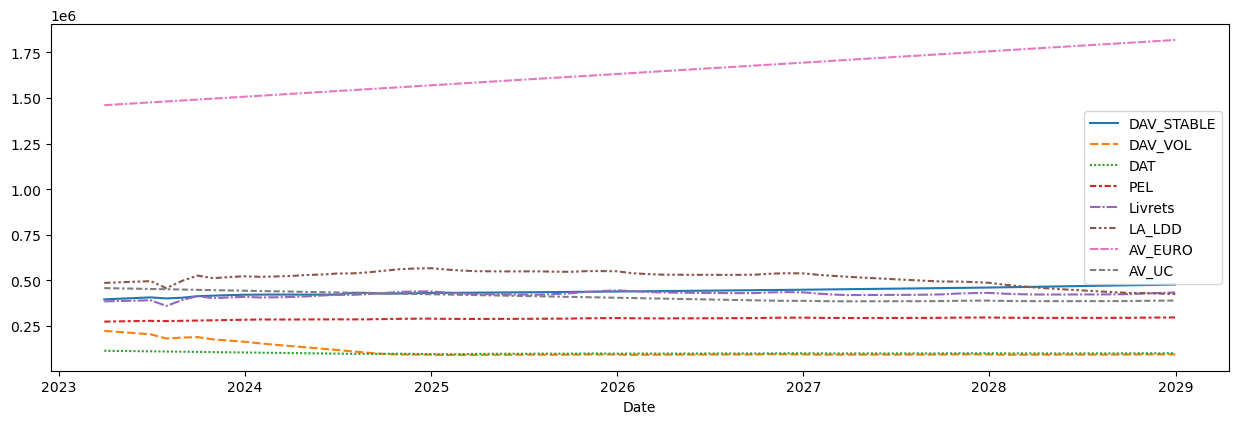

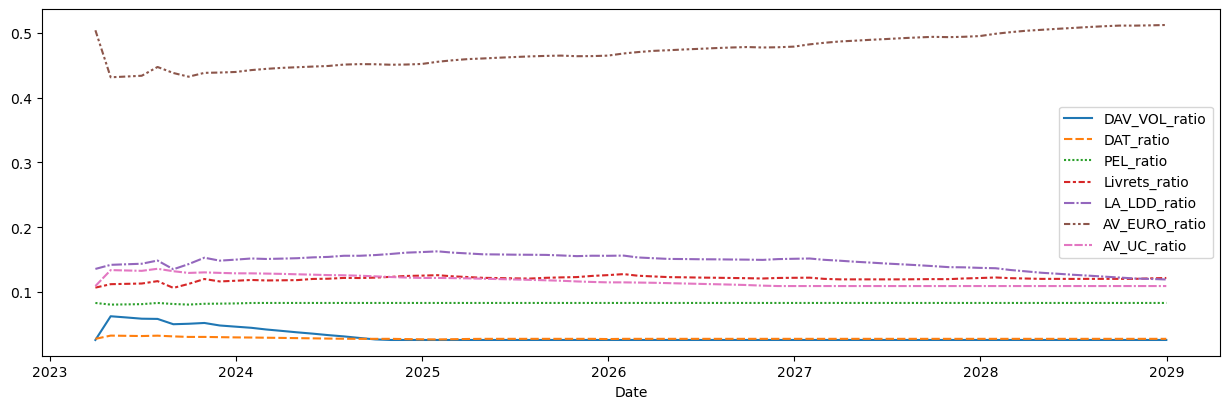

In [72]:
''' Ménages - Capitalisation et arbitrage des encours '''

target_to_drivers = {
    "Menages_AV_Euro_Corrige": ["Euribor_3M_6MROLLING", "OAT_10Y_3YROLLING"],
    "Menages_AV_UC": ["Epargne_menages_ratio_6MROLLING", "CAC40_6MROLLING"],
    "Menages_DAT": ["Epargne_menages_ratio_6MROLLING"],
    "Menages_DAV_Vol": ['Euribor_3M_6MROLLING'], 
    "Menages_LA_LDD": ["LA_rate", 'Inflation'],
    "Menages_Livrets": ["Inflation", "LA_rate"],
    "Menages_PEL": ["Epargne_menages_ratio_6MROLLING", "LA_rate_6MROLLING"]
}

renaming = {
    "Menages_AV_Euro_Corrige": 'AV_EURO',
    "Menages_AV_UC": 'AV_UC',
    "Menages_DAT": 'DAT',
    "Menages_DAV_Stable": 'DAV_STABLE',
    "Menages_DAV_Vol": 'DAV_VOL',
    "Menages_LA_LDD": 'LA_LDD',
    "Menages_Livrets": 'Livrets',
    "Menages_PEL": 'PEL'
}

renaming_reversed = {v: k for k, v in renaming.items()}

products_arbitrable = {
    'DAV_STABLE': False,
    'DAV_VOL': True,
    'DAT': True,
    'PEL': True,
    'Livrets': True,
    'LA_LDD': True,
    'Autres': False,
    'AV_EURO': True,
    'AV_UC': True
}

df_projection['DAV_VOL_taux'] = 0
df_projection['DAV_STABLE_taux'] = 0
df_projection['DAT_taux'] = 0.000541666666666667 * 12
df_projection['PEL_taux'] = 0.0259916666666667
df_projection['Livrets_taux'] = 0.000075 * (df_projection['LA_rate']/(df_projection['LA_rate'].shift(1).fillna(1))).cumprod() * 12
df_projection['LA_LDD_taux'] = df_projection['LA_rate'] / 100
df_projection['Autres_taux'] = df_projection['Livrets_taux']
coeffs = (0.0104499019918081, 0.591229809892125)
df_projection['AV_EURO_taux'] = (coeffs[0] + coeffs[1] * df_projection['OAT_10Y_L5Y'] / 100)
coeffs = (0., 0.8)
df_projection['AV_UC_taux'] = (coeffs[0] + coeffs[1] * df_projection['CAC40_Diff'] / df_projection['CAC40'].shift(1))


# Scenarios (initial at 2022-12)
df_bdf_quarterly = df_bdf_quarterly[df_bdf_quarterly['Date'] <= projection_start_date]
df_bdf_quarterly = df_bdf_quarterly.sort_values('Date', ascending=True)
df_bdf_monthly = df_bdf_monthly[df_bdf_monthly['Date'] <= projection_start_date]
df_bdf_monthly = df_bdf_monthly.sort_values('Date', ascending=True)

products_initial_balance = {
    'DAV_STABLE': df_projection['dav_part_stable'].values[0],
    'DAV_VOL': df_bdf_monthly['Dépôts à vue des ménages et ISBLSM résidents, encours'].values[-1] - df_projection['dav_part_stable'].values[0],
    'DAT':  df_bdf_monthly['Dépôts à terme des ménages et ISBLSM résidents, encours'].values[-1] - df_bdf_monthly['PEL des ménages résidents, encours'].values[-1],
    'PEL':  df_bdf_monthly['PEL des ménages résidents, encours'].values[-1],
    'Livrets':  df_bdf_monthly["Livrets d'épargne des ménages et ISBLSM résidents, encours"].values[-1] - (df_bdf_monthly["Livrets A des ménages et ISBLSM résidents, encours"].values[-1] + df_bdf_monthly["Livrets de développement durable et solidaire des ménages résidents, encours"].values[-1]), 
    'LA_LDD':  df_bdf_monthly["Livrets A des ménages et ISBLSM résidents, encours"].values[-1] + df_bdf_monthly["Livrets de développement durable et solidaire des ménages résidents, encours"].values[-1],
    'Autres':  (df_bdf_quarterly['Actif Toutes dénominations monétaires des ménages vis-à-vis de toutes contreparties - encours de monnaie et dépôts'].values[-1]) / (3 * 1e3) - (df_bdf_monthly['Dépôts à vue des ménages et ISBLSM résidents, encours'].values[-1] + df_bdf_monthly['Dépôts à terme des ménages et ISBLSM résidents, encours'].values[-1] + df_bdf_monthly["Livrets d'épargne des ménages et ISBLSM résidents, encours"].values[-1]),
    'AV_EURO':  df_bdf_quarterly['Assurance-vie support euro, actif des ménages, encours trimestriel'].values[-1],
    'AV_UC': df_bdf_quarterly['Assurance-vie en unités de compte, actif des ménages, encours trimestriel'].values[-1]
}

products_interests_frequency = {
    'DAV_STABLE': 1,
    'DAV_VOL':  1,
    'DAT': 12,
    'PEL': 12,
    'Livrets': 12, 
    'LA_LDD': 12,
    'Autres': 12,
    'AV_EURO': 12,
    'AV_UC': 12,
}

products_liquidity = load(f'models/products_liquidity.joblib')
# for (p, v) in products_arbitrable.items():
#     quantile = 0.75
#     if v:
#         sub_df = np.abs(df_train[renaming_reversed[p]] - df_train[renaming_reversed[p]].shift(1))
#         sub_df = sub_df[sub_df > 1e-6]
#         products_liquidity[p] = sub_df.quantile(quantile)

products_is_liquid = {
    'DAV_STABLE': True,
    'DAV_VOL':  True,
    'DAT': False,
    'PEL': False,
    'Livrets': True, 
    'LA_LDD': True,
    'Autres': False,
    'AV_EURO': False,
    'AV_UC': False,
}


# '''Ratio & Feature engineering'''


# df_projection['LA_rate'] = df_projection['LA_LDD_taux']*100
# df_projection['LA_minus_OAT'] = df['LA_rate'] - df['OAT_10Y'].rolling(window=5, min_periods=1).mean()
# df_projection['OAT_10Y_3YROLLING'] = df['OAT_10Y'].rolling(window=12*3, min_periods=1).mean()
# df_projection['Epargne_menages_ratio'] = df_projection['Epargne_menages'] / df_projection['RDB']
# df_projection['Consommation_menages_courant_ratio'] = df_projection['Consommation_menages_courant'] / df_projection['RDB']

for (k,v) in target_to_drivers.items():
    for driver in v:
        if "_6MROLLING" in driver:
            df_projection[driver] = df_projection['_'.join(driver.split('_')[:-1])].rolling(6, min_periods=1).mean()

for (k,v) in target_to_drivers.items():
    df_projection[f"{renaming[k]}_ratio"] = models[k].predict(df_projection[target_to_drivers[k]])
    df_projection[f"{renaming[k]}_ratio"] = df_projection[f"{renaming[k]}_ratio"].apply(lambda x: max(x,0))


def projection_non_arbitrable(df, i, p):
    if p == 'Autres':
        return df.loc[i - 1, p] 
    elif p == 'DAV_STABLE':
        return df.loc[i, "dav_part_stable"]


def generate_interests(df, i, p, frequency):
    return 0. # Interests are already included in households revenue
    # depth = max(i, frequency)
    # # generate interests
    # if df.loc[i, "Date"].month % frequency == 0:
    #     return (df.loc[i - frequency + 1: i, p] * df.loc[i - frequency + 1: i, f"{p}_taux"]).sum() / 12
    # return 0

Encours_arbitrable = sum([products_initial_balance[k] for k in products_initial_balance.keys() if products_arbitrable[k]])
df_projection['Encours_arbitrable'] = 0.
interests = 0.
for p in products_arbitrable.keys():
    df_projection[p] = 0.
for p in products_interests_frequency.keys():
    df_projection[f"{p}_interests"] = 0.

df_projection.reset_index(inplace=True, drop=True)
for i, row in df_projection.iterrows():
    if i == 0:
        df_projection.loc[i, 'Encours_arbitrable'] = Encours_arbitrable
        for p in products_arbitrable.keys():
            df_projection.loc[i, p] = products_initial_balance[p]      
    else:
        df_projection.loc[i, 'Encours_arbitrable'] = df_projection.loc[i - 1, 'Encours_arbitrable'] + df_projection.loc[i, 'flux_a_epargner'] + interests
        for p in products_arbitrable.keys():
            if products_arbitrable[p]:
                df_projection.loc[i, p] = df_projection.loc[i, f"{p}_ratio"] * df_projection.loc[i, 'Encours_arbitrable']
            else:
                df_projection.loc[i, p] = projection_non_arbitrable(df_projection, i, p)
        # Applying repartition effects
        standardization_factor_liquid = 0
        standardization_factor_non_liquid = 0
        for p in products_arbitrable.keys():
            if products_arbitrable[p]:
                current_val = df_projection.loc[i - 1, p]
                target_val = df_projection.loc[i, p]
                liquidity = products_liquidity[p]
                new_val = current_val + np.sign(target_val - current_val) * min(liquidity, np.abs(target_val - current_val))
                df_projection.loc[i, f"{p}_ratio"] = new_val / df_projection.loc[i, 'Encours_arbitrable']
                standardization_factor_liquid += products_is_liquid[p] * new_val / df_projection.loc[i, 'Encours_arbitrable']
                standardization_factor_non_liquid += (1 - products_is_liquid[p]) * new_val / df_projection.loc[i, 'Encours_arbitrable']
        encours_restant = df_projection.loc[i, 'Encours_arbitrable']
        for p in products_arbitrable.keys():
            if products_arbitrable[p]:
                if not products_is_liquid[p]:
                    df_projection.loc[i, p] = df_projection.loc[i, f"{p}_ratio"] * df_projection.loc[i, 'Encours_arbitrable']
                    encours_restant -= df_projection.loc[i, p]
        for p in products_arbitrable.keys():
            if products_arbitrable[p]:
                if products_is_liquid[p]:
                    df_projection.loc[i, p] = df_projection.loc[i, f"{p}_ratio"] * encours_restant / standardization_factor_liquid
        # Generating interests
        interests = 0.
        for p in products_interests_frequency.keys():
            df_projection.loc[i, f"{p}_interests"] = generate_interests(df_projection, i, p, products_interests_frequency[p])
            interests += generate_interests(df_projection, i, p, products_interests_frequency[p])

df_projection['DAV'] = df_projection['DAV_STABLE'] + df_projection['DAV_VOL']


df_plot = df_projection.copy()
fig, ax =plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
figure = sns.lineplot(data=df_plot.set_index("Date")[[k for k in products_initial_balance.keys() if k!='Autres']], ax=ax)
fig.show()

df_plot = df_projection.copy()
fig, ax =plt.subplots(1,1)
fig.set_figheight(4.5)
fig.set_figwidth(15.2)
L = [f"{k}_ratio" for k in products_arbitrable.keys() if products_arbitrable[k]]
L = [p for p in L if p != 'Autres_ratio']
figure = sns.lineplot(data=df_plot.set_index("Date")[L], ax=ax)
fig.show()

""" Export des résultats vers Excel """

df_projection[[
    'Date',
    'DAV',
    'DAT',
    'PEL',
    'Livrets',
    'LA_LDD',
    'AV_UC',
    'AV_EURO',
    'credit_immo',
    'credit_conso'
]].to_excel("C:/Users/admin/Desktop/Projet_A-main/Python package/outputs_ME/projection_menages.xlsx", index=False)

In [73]:
''' SNF - Capitalisation et arbitrage des encours '''

df_projection['reference_rate_growth'] = model_SNF_rate.predict(df_projection[['Euribor_3M']])
df_projection['reference_rate_growth'] = (df_projection["reference_rate_growth"] / df_projection["reference_rate_growth"].shift(1)).fillna(1)
df_projection['reference_rate_growth'] = df_projection['reference_rate_growth'].cumprod()
df_snf_rates = df_bdf_monthly[['Date', "Titres d'OPC monétaires, taux de valorisation de l'encours", "Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans"]]
df_projection["Titres d'OPC monétaires, taux de valorisation de l'encours"] = df_snf_rates["Titres d'OPC monétaires, taux de valorisation de l'encours"].values[-1] * df_projection['reference_rate_growth']
df_projection["Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans"] = df_snf_rates["Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans"].values[-1] * df_projection['reference_rate_growth']

arbitrage_drivers = ["Taux d'intérêt sur contrats nouveaux, DAT, SNF, durée supérieure à 2 ans", "Titres d'OPC monétaires, taux de valorisation de l'encours"]

old_drivers = df_bdf_monthly[df_bdf_monthly['Date'] < projection_start_date]
# old_drivers = old_drivers[['Date'] + arbitrage_drivers]
new_drivers = df_projection[['Date', 'dav_part_stable_SNF'] + arbitrage_drivers]
new_drivers = new_drivers.merge(df_bdf_monthly[df_bdf_monthly['Date'] == projection_start_date].drop(columns=arbitrage_drivers), on='Date', how='left')
df_arbitrage_snf = pd.concat([old_drivers, new_drivers], axis=0, ignore_index=True)
# df_arbitrage_snf = df_arbitrage_snf.merge(df_dav_SNF_histo[['Date', 'dav_part_stable_SNF_histo']])

df_arbitrage_snf["alpha_SNF_DAV_Vol"] = models_SNF['SNF_DAV_Vol'].predict(df_arbitrage_snf[arbitrage_drivers].fillna(0))
df_arbitrage_snf["alpha_SNF_DAT"] = models_SNF['SNF_DAT'].predict(df_arbitrage_snf[arbitrage_drivers].fillna(0))
df_arbitrage_snf["alpha_SNF_OPC"] = models_SNF['SNF_OPC'].predict(df_arbitrage_snf[arbitrage_drivers].fillna(0))
df_arbitrage_snf["alpha_SNF_DAV_Vol"] = df_arbitrage_snf["alpha_SNF_DAV_Vol"].apply(np.exp)
df_arbitrage_snf["alpha_SNF_DAT"] = df_arbitrage_snf["alpha_SNF_DAT"].apply(np.exp)
df_arbitrage_snf["alpha_SNF_OPC"] = df_arbitrage_snf["alpha_SNF_OPC"].apply(np.exp)
predict_sum = df_arbitrage_snf[['alpha_SNF_DAV_Vol', 'alpha_SNF_DAT', 'alpha_SNF_OPC']].sum(axis=1)
df_arbitrage_snf["alpha_SNF_DAV_Vol"] = df_arbitrage_snf["alpha_SNF_DAV_Vol"] / predict_sum
df_arbitrage_snf["alpha_SNF_DAT"] = df_arbitrage_snf["alpha_SNF_DAT"]  / predict_sum
df_arbitrage_snf["alpha_SNF_OPC"] = df_arbitrage_snf["alpha_SNF_OPC"] / predict_sum

df_arbitrage_snf = df_arbitrage_snf.merge(df_dav_SNF_histo[['Date', 'dav_part_stable_SNF_histo']], on='Date', how='left').merge(df_bdf_quarterly, on='Date', how='left')
df_arbitrage_snf['dav_part_stable_SNF'] = df_arbitrage_snf['dav_part_stable_SNF'].fillna(df_arbitrage_snf['dav_part_stable_SNF_histo'])
df_arbitrage_snf['SNF_DAV_Vol'] = df_arbitrage_snf['Dépôts à vue des SNF résidentes, encours'] - df_arbitrage_snf['dav_part_stable_SNF']
df_arbitrage_snf['SNF_DAT'] = df_arbitrage_snf["Dépôts à terme des SNF résidentes, encours"]
df_arbitrage_snf['SNF_OPC'] = df_arbitrage_snf["Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours d'OPC monétaires"].bfill() / 1e3

total_sum = df_arbitrage_snf[['SNF_DAV_Vol', 'SNF_DAT', 'SNF_OPC']].sum(axis=1)
df_arbitrage_snf["alpha_SNF_DAV_Vol_histo"] = (df_arbitrage_snf["SNF_DAV_Vol"] / total_sum)
df_arbitrage_snf["alpha_SNF_DAT_histo"] = (df_arbitrage_snf["SNF_DAT"] / total_sum)
df_arbitrage_snf["alpha_SNF_OPC_histo"] = (df_arbitrage_snf["SNF_OPC"] / total_sum)


is_na = df_arbitrage_snf["alpha_SNF_DAV_Vol_histo"].isnull() | df_arbitrage_snf["alpha_SNF_DAT_histo"].isnull() | df_arbitrage_snf["alpha_SNF_OPC_histo"].isnull()
df_arbitrage_snf["alpha_SNF_DAV_Vol"] = (~is_na * df_arbitrage_snf["alpha_SNF_DAV_Vol_histo"]).fillna(0) + (is_na * df_arbitrage_snf["alpha_SNF_DAV_Vol"]).fillna(0)
df_arbitrage_snf["alpha_SNF_DAT"] = (~is_na * df_arbitrage_snf["alpha_SNF_DAT_histo"]).fillna(0) + (is_na * df_arbitrage_snf["alpha_SNF_DAT"]).fillna(0)
df_arbitrage_snf["alpha_SNF_OPC"] = (~is_na * df_arbitrage_snf["alpha_SNF_OPC_histo"]).fillna(0) + (is_na * df_arbitrage_snf["alpha_SNF_OPC"]).fillna(0)

df_arbitrage_snf["alpha_SNF_DAV_Vol"] = df_arbitrage_snf["alpha_SNF_DAV_Vol"].rolling(12, min_periods=1).mean()
df_arbitrage_snf["alpha_SNF_DAT"] = df_arbitrage_snf["alpha_SNF_DAT"].rolling(12, min_periods=1).mean()
df_arbitrage_snf["alpha_SNF_OPC"] = df_arbitrage_snf["alpha_SNF_OPC"].rolling(12, min_periods=1).mean()
predict_sum = df_arbitrage_snf[['alpha_SNF_DAV_Vol', 'alpha_SNF_DAT', 'alpha_SNF_OPC']].sum(axis=1)
df_arbitrage_snf["alpha_SNF_DAV_Vol"] = (df_arbitrage_snf["alpha_SNF_DAV_Vol"] / predict_sum)
df_arbitrage_snf["alpha_SNF_DAT"] = (df_arbitrage_snf["alpha_SNF_DAT"] / predict_sum)
df_arbitrage_snf["alpha_SNF_OPC"] = (df_arbitrage_snf["alpha_SNF_OPC"] / predict_sum)
df_arbitrage_snf = df_arbitrage_snf[['Date', 'alpha_SNF_DAV_Vol', 'alpha_SNF_DAT', 'alpha_SNF_OPC']]

df_projection = df_projection.merge(df_arbitrage_snf, on='Date', how='left')

products_initial_balance = {
    'SNF_DAV_STABLE': df_projection['dav_part_stable_SNF'].values[0],
    'SNF_DAV_Vol': df_bdf_monthly['Dépôts à vue des SNF résidentes, encours'].values[-1] - df_projection['dav_part_stable_SNF'].values[0],
    'SNF_DAT':  df_bdf_monthly["Dépôts à terme des SNF résidentes, encours"].values[-1],
    'SNF_OPC':  df_bdf_quarterly["Actif Toutes dénominations monétaires des SNF vis-à-vis de toutes contreparties - encours d'OPC monétaires"].values[-1] / 1e3
}

Encours_arbitrable_SNF = products_initial_balance['SNF_DAV_Vol'] + products_initial_balance['SNF_DAT'] + products_initial_balance['SNF_OPC']
Encours_arbitrable_SNF = Encours_arbitrable_SNF + df_projection['SNF_flux_a_epargner'].fillna(0).cumsum() - df_projection['dav_part_stable_SNF'].diff().fillna(0).cumsum()
df_projection['Encours_arbitrable_SNF'] = Encours_arbitrable_SNF.apply(lambda x: max(x, 0))

df_projection['SNF_DAV_Vol'] = df_projection['Encours_arbitrable_SNF'] * df_projection['alpha_SNF_DAV_Vol']
df_projection['SNF_DAT'] = df_projection['Encours_arbitrable_SNF'] * df_projection['alpha_SNF_DAT']
df_projection['SNF_OPC'] = df_projection['Encours_arbitrable_SNF'] * df_projection['alpha_SNF_OPC']

df_projection['SNF_DAV_Vol'] = products_initial_balance['SNF_DAV_Vol'] * (df_projection['SNF_DAV_Vol'] / df_projection['SNF_DAV_Vol'].shift(1)).fillna(1).cumprod()
df_projection['SNF_DAT'] = products_initial_balance['SNF_DAT'] * (df_projection['SNF_DAT'] / df_projection['SNF_DAT'].shift(1)).fillna(1).cumprod()
df_projection['SNF_OPC'] = products_initial_balance['SNF_OPC'] * (df_projection['SNF_OPC'] / df_projection['SNF_OPC'].shift(1)).fillna(1).cumprod()

df_projection['SNF_DAV'] = df_projection['SNF_DAV_Vol'] + df_projection['dav_part_stable_SNF']
df_projection = df_projection.reset_index(drop=True)
# df_projection.loc[0, 'SNF_DAV'] = products_initial_balance['SNF_DAV_Vol'] + products_initial_balance['SNF_DAV_STABLE']
# df_projection.loc[0, 'SNF_DAT'] = products_initial_balance['SNF_DAT']
# df_projection.loc[0, 'SNF_OPC'] = products_initial_balance['SNF_OPC']


df_projection[[
    'Date',
    'SNF_DAV',
    'SNF_DAT',
    'SNF_OPC',
    'credit_invest',
    'credit_treso',
]].to_excel("C:/Users/admin/Desktop/Projet_A-main/Python package/outputs_ME/outputs/projection_SNF.xlsx", index=False)

C:\Users\admin\Anaconda\anaconda3\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\admin\AppData\Local\Temp\ipykernel_17776\192174047.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_projection["Titres d'OPC monétaires, taux de valorisation de l'encours"] = df_snf_rates["Titres d'OPC monétaires, taux de valorisation de l'encours"].values[-1] * df_projection['reference_rate_growth']
C:\Users\admin\AppData\Local\Temp\ipykernel_17776\192174047.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1

ValueError: X has 2 features, but DecisionTreeRegressor is expecting 1 features as input.